In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import pickle

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

In [3]:
## 폰트 설정 (Windows)
plt.rc('font', family='Malgun Gothic')

# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기

In [4]:
df_merged = pd.read_excel("./기숙사비예측통일데이터.xlsx")

In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   기준연도            115 non-null    int64  
 1   지역              115 non-null    object 
 2   학교              115 non-null    object 
 3   재학생수            115 non-null    int64  
 4   총 실수            115 non-null    int64  
 5   건물명             115 non-null    object 
 6   준공연도            115 non-null    int64  
 7   운영된 기간          115 non-null    int64  
 8   총사업비(백만원)       115 non-null    int64  
 9   수용인원(명)         115 non-null    int64  
 10  연면적(미터제곱)       115 non-null    int64  
 11  재원(공자기금)        115 non-null    int64  
 12  재원(주택기금)        115 non-null    int64  
 13  재원(자체)          115 non-null    int64  
 14  자체재원 비율         115 non-null    float64
 15  인당 연면적          115 non-null    float64
 16  기숙사중행복기숙사점유율    115 non-null    float64
 17  실당 인원수          115 non-null    flo

# 모델에 쓸 데이터 모으기

In [6]:
df_cleaned = df_merged.drop(["기준연도", "지역", "학교", "건물명", '인당 연면적',
                            '준공연도', '총사업비(백만원)', '기숙사중행복기숙사점유율', '수용인원당 사업비',
                              '수용인원당 자체 재원','기준연도별_지역별_인구밀도', '소비자물가지수 학교기숙사비',
                              '년도별 평균 기준금리'], axis=1)

In [7]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   재학생수       115 non-null    int64  
 1   총 실수       115 non-null    int64  
 2   운영된 기간     115 non-null    int64  
 3   수용인원(명)    115 non-null    int64  
 4   연면적(미터제곱)  115 non-null    int64  
 5   재원(공자기금)   115 non-null    int64  
 6   재원(주택기금)   115 non-null    int64  
 7   재원(자체)     115 non-null    int64  
 8   자체재원 비율    115 non-null    float64
 9   실당 인원수     115 non-null    float64
 10  의무식dummy   115 non-null    int64  
 11  서울dummy    115 non-null    int64  
 12  경기dummy    115 non-null    int64  
 13  광역시dummy   115 non-null    int64  
 14  분교dummy    115 non-null    int64  
 15  학급dummy    115 non-null    int64  
 16  총기숙사비      115 non-null    int64  
dtypes: float64(2), int64(15)
memory usage: 15.4 KB


# EDA
 

In [8]:
df_EDA = df_merged.copy()

In [9]:
# 더미들을 제외한 수치형 변수들
df_EDA4numberic = df_EDA.drop(["기준연도","지역", "학교", "건물명","준공연도",'인당 연면적',
                               '총사업비(백만원)', '기숙사중행복기숙사점유율', '수용인원당 사업비',
                              '수용인원당 자체 재원','기준연도별_지역별_인구밀도', '소비자물가지수 학교기숙사비',
                              '년도별 평균 기준금리',                              
                               "서울dummy","경기dummy", "광역시dummy", "분교dummy", "학급dummy", "의무식dummy", ], axis=1)

## 지역별 barplot 보기 (주의 이건 학교 2024년 데이터이다.)

In [10]:
df_EDA2024 = df_EDA[df_EDA["기준연도"] == 2024].copy()

df_EDA2024['1인당 평균 기숙사비(월)(원)'] = df_EDA2024["총기숙사비"]//df_EDA2024["수용인원(명)"]

In [11]:
df_EDA2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 36
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   기준연도               37 non-null     int64  
 1   지역                 37 non-null     object 
 2   학교                 37 non-null     object 
 3   재학생수               37 non-null     int64  
 4   총 실수               37 non-null     int64  
 5   건물명                37 non-null     object 
 6   준공연도               37 non-null     int64  
 7   운영된 기간             37 non-null     int64  
 8   총사업비(백만원)          37 non-null     int64  
 9   수용인원(명)            37 non-null     int64  
 10  연면적(미터제곱)          37 non-null     int64  
 11  재원(공자기금)           37 non-null     int64  
 12  재원(주택기금)           37 non-null     int64  
 13  재원(자체)             37 non-null     int64  
 14  자체재원 비율            37 non-null     float64
 15  인당 연면적             37 non-null     float64
 16  기숙사중행복기숙사점유율       37 non-null   

### 지역별 행복기숙사 수

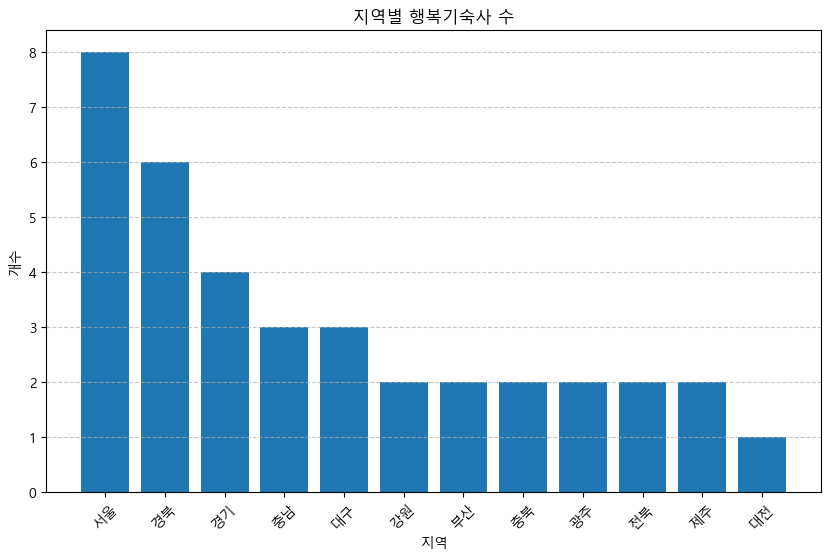

In [12]:

# 지역별 행복기숙사 수 계산
region_number = df_EDA2024["지역"].value_counts().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_number.index, region_number.values)

plt.title('지역별 행복기숙사 수')
plt.xlabel('지역')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 총 대학 재학생수

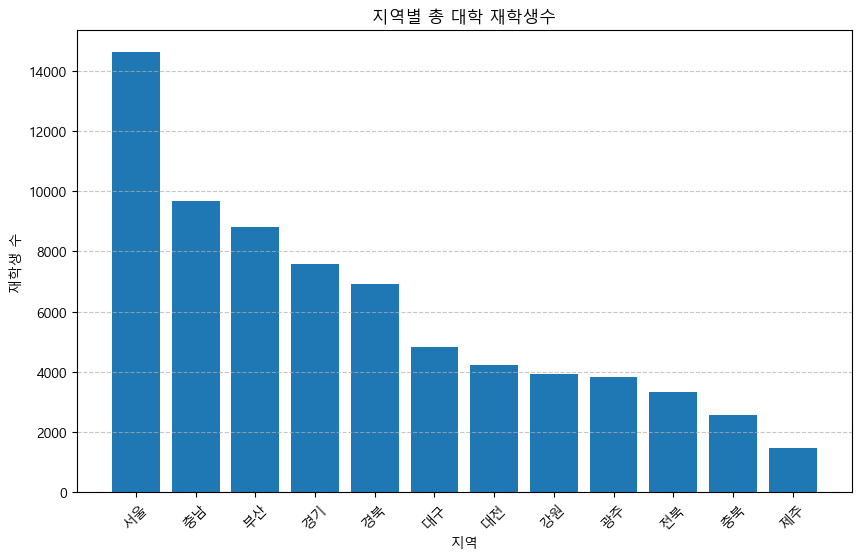

In [13]:
# 지역별 기숙사 실수 계산
region_gross_people = df_EDA2024.groupby('지역')['재학생수'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_gross_people.index, region_gross_people.values)

plt.title('지역별 총 대학 재학생수')
plt.xlabel('지역')
plt.ylabel('재학생 수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 평균 기숙사비

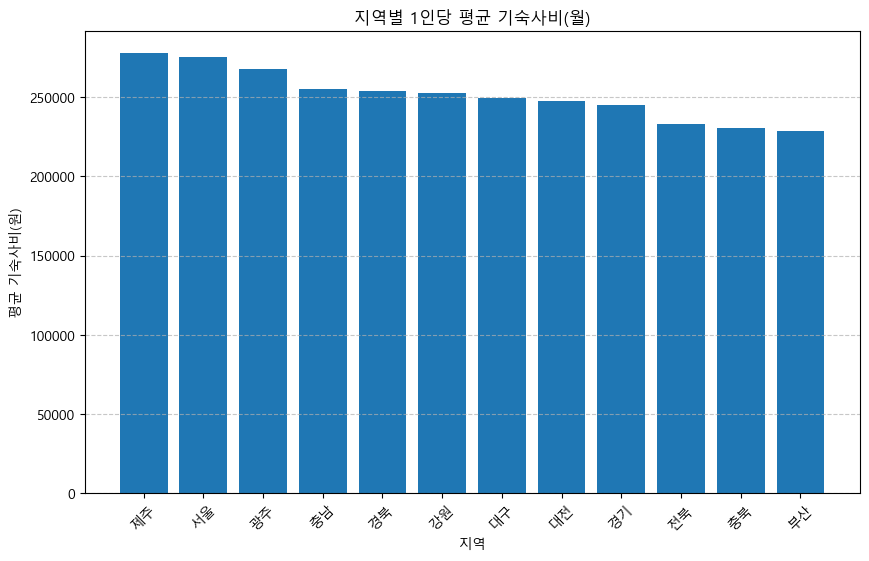

In [14]:

# 지역별 평균 기숙사비 계산
region_cost = df_EDA2024.groupby('지역')['1인당 평균 기숙사비(월)(원)'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_cost.index, region_cost.values)

plt.title('지역별 1인당 평균 기숙사비(월)')
plt.xlabel('지역')
plt.ylabel('평균 기숙사비(원)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 기숙사 실수

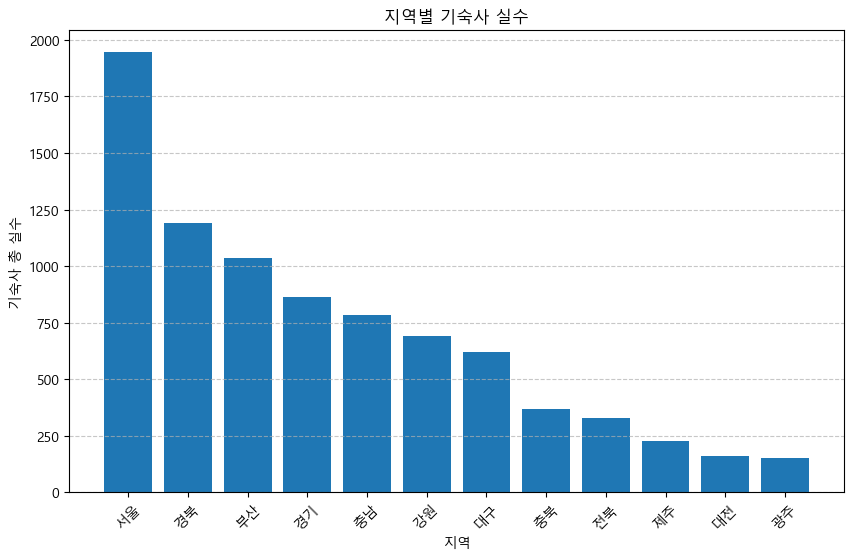

In [15]:

# 지역별 기숙사 실수 계산
region_room_num = df_EDA2024.groupby('지역')['총 실수'].sum().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_room_num.index, region_room_num.values)

plt.title('지역별 기숙사 실수')
plt.xlabel('지역')
plt.ylabel('기숙사 총 실수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 총 수용인원

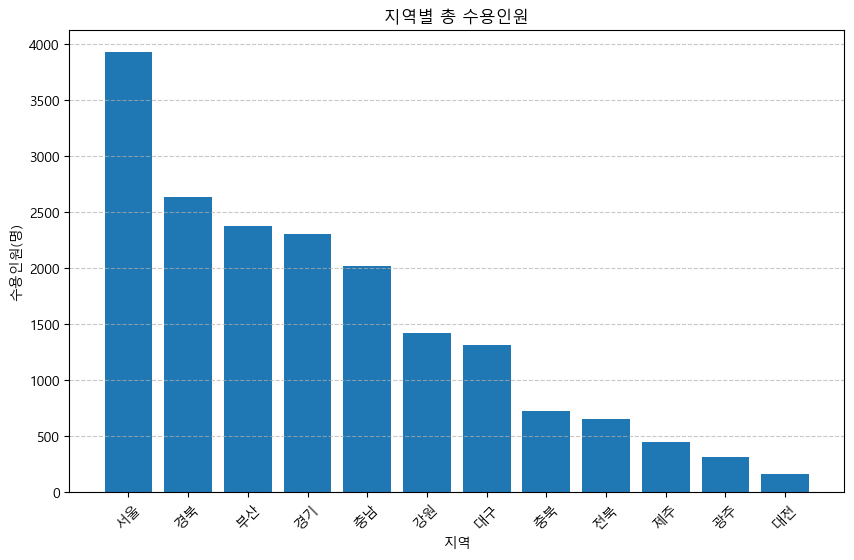

In [16]:
# 지역별 기숙사 실수 계산
region_capacity = df_EDA2024.groupby('지역')['수용인원(명)'].sum().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_capacity.index, region_capacity.values)

plt.title('지역별 총 수용인원')
plt.xlabel('지역')
plt.ylabel('수용인원(명)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#3# 지역별 평균 실당 인원수

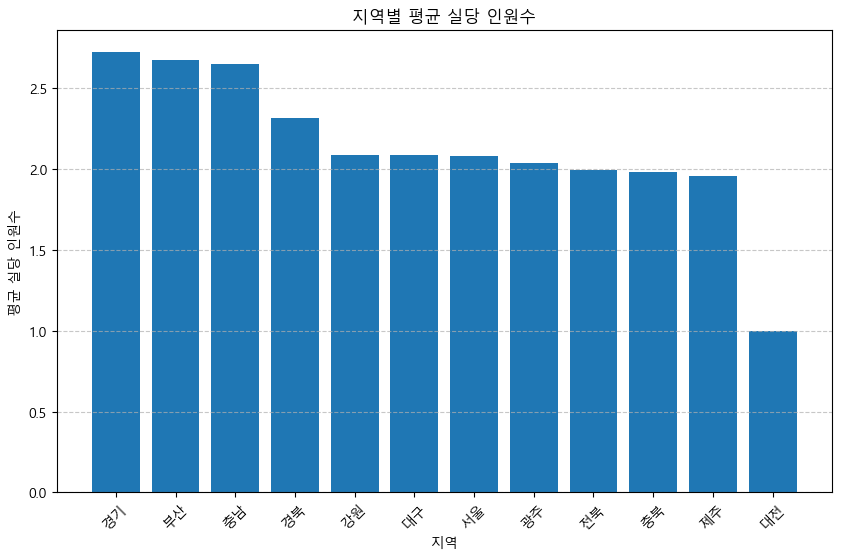

In [17]:
# 지역별 기숙사 실수 계산
region_room_people = df_EDA2024.groupby('지역')['실당 인원수'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_room_people.index, region_room_people.values)

plt.title('지역별 평균 실당 인원수')
plt.xlabel('지역')
plt.ylabel('평균 실당 인원수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 1인당 평균 기숙사비(월)(원) 

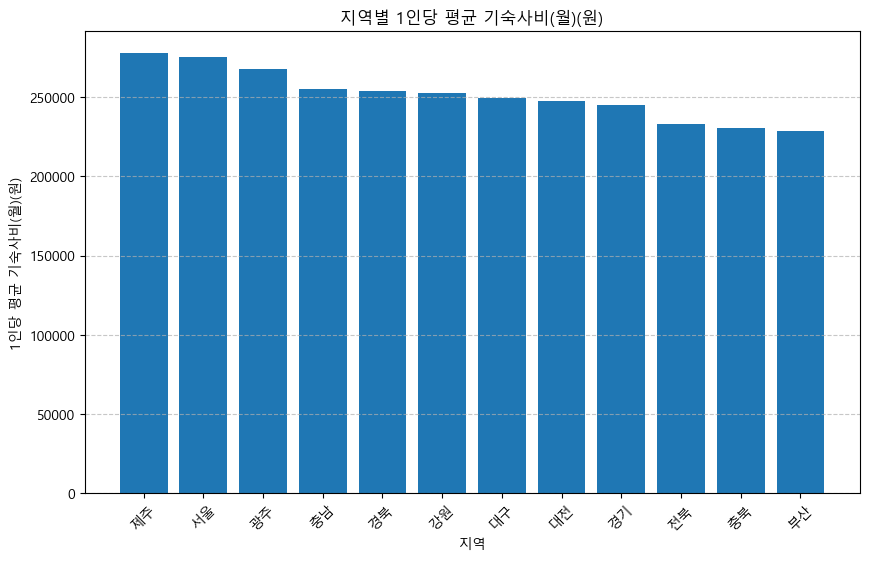

In [18]:
# 지역별 1인당 평균 기숙사비(월)(원) 계산
region_avg_per_cost = df_EDA2024.groupby('지역')['1인당 평균 기숙사비(월)(원)'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_avg_per_cost.index, region_avg_per_cost.values)

plt.title('지역별 1인당 평균 기숙사비(월)(원)')
plt.xlabel('지역')
plt.ylabel('1인당 평균 기숙사비(월)(원)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 평균 자체재원 비율

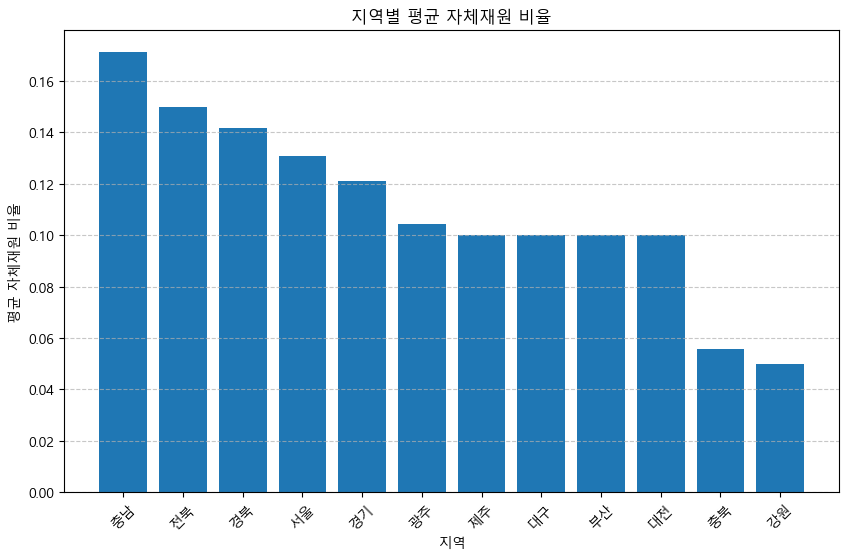

In [19]:
# 지역별 평균 자체재원 비율 계산
region_self_cost = df_EDA2024.groupby('지역')['자체재원 비율'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_self_cost.index, region_self_cost.values)

plt.title('지역별 평균 자체재원 비율')
plt.xlabel('지역')
plt.ylabel('평균 자체재원 비율')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 지역별 평균 총사업비(백만원)

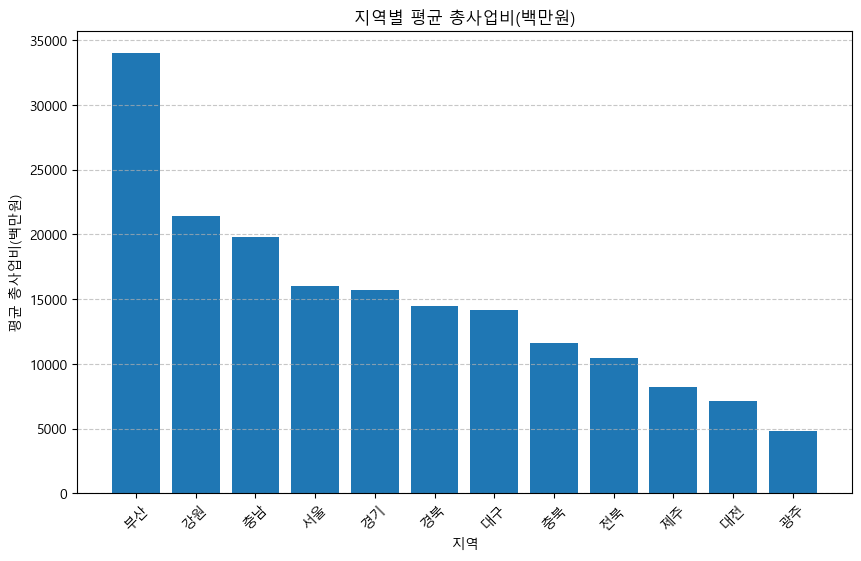

In [20]:
# 지역별 평균 총사업비(백만원)
region_avg_gross_funding = df_EDA2024.groupby('지역')['총사업비(백만원)'].mean().sort_values(ascending=False)

# 그래프
plt.figure(figsize=(10,6))
plt.bar(region_avg_gross_funding.index, region_avg_gross_funding.values)

plt.title('지역별 평균 총사업비(백만원)')
plt.xlabel('지역')
plt.ylabel('평균 총사업비(백만원)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 한방에 barplot 보기

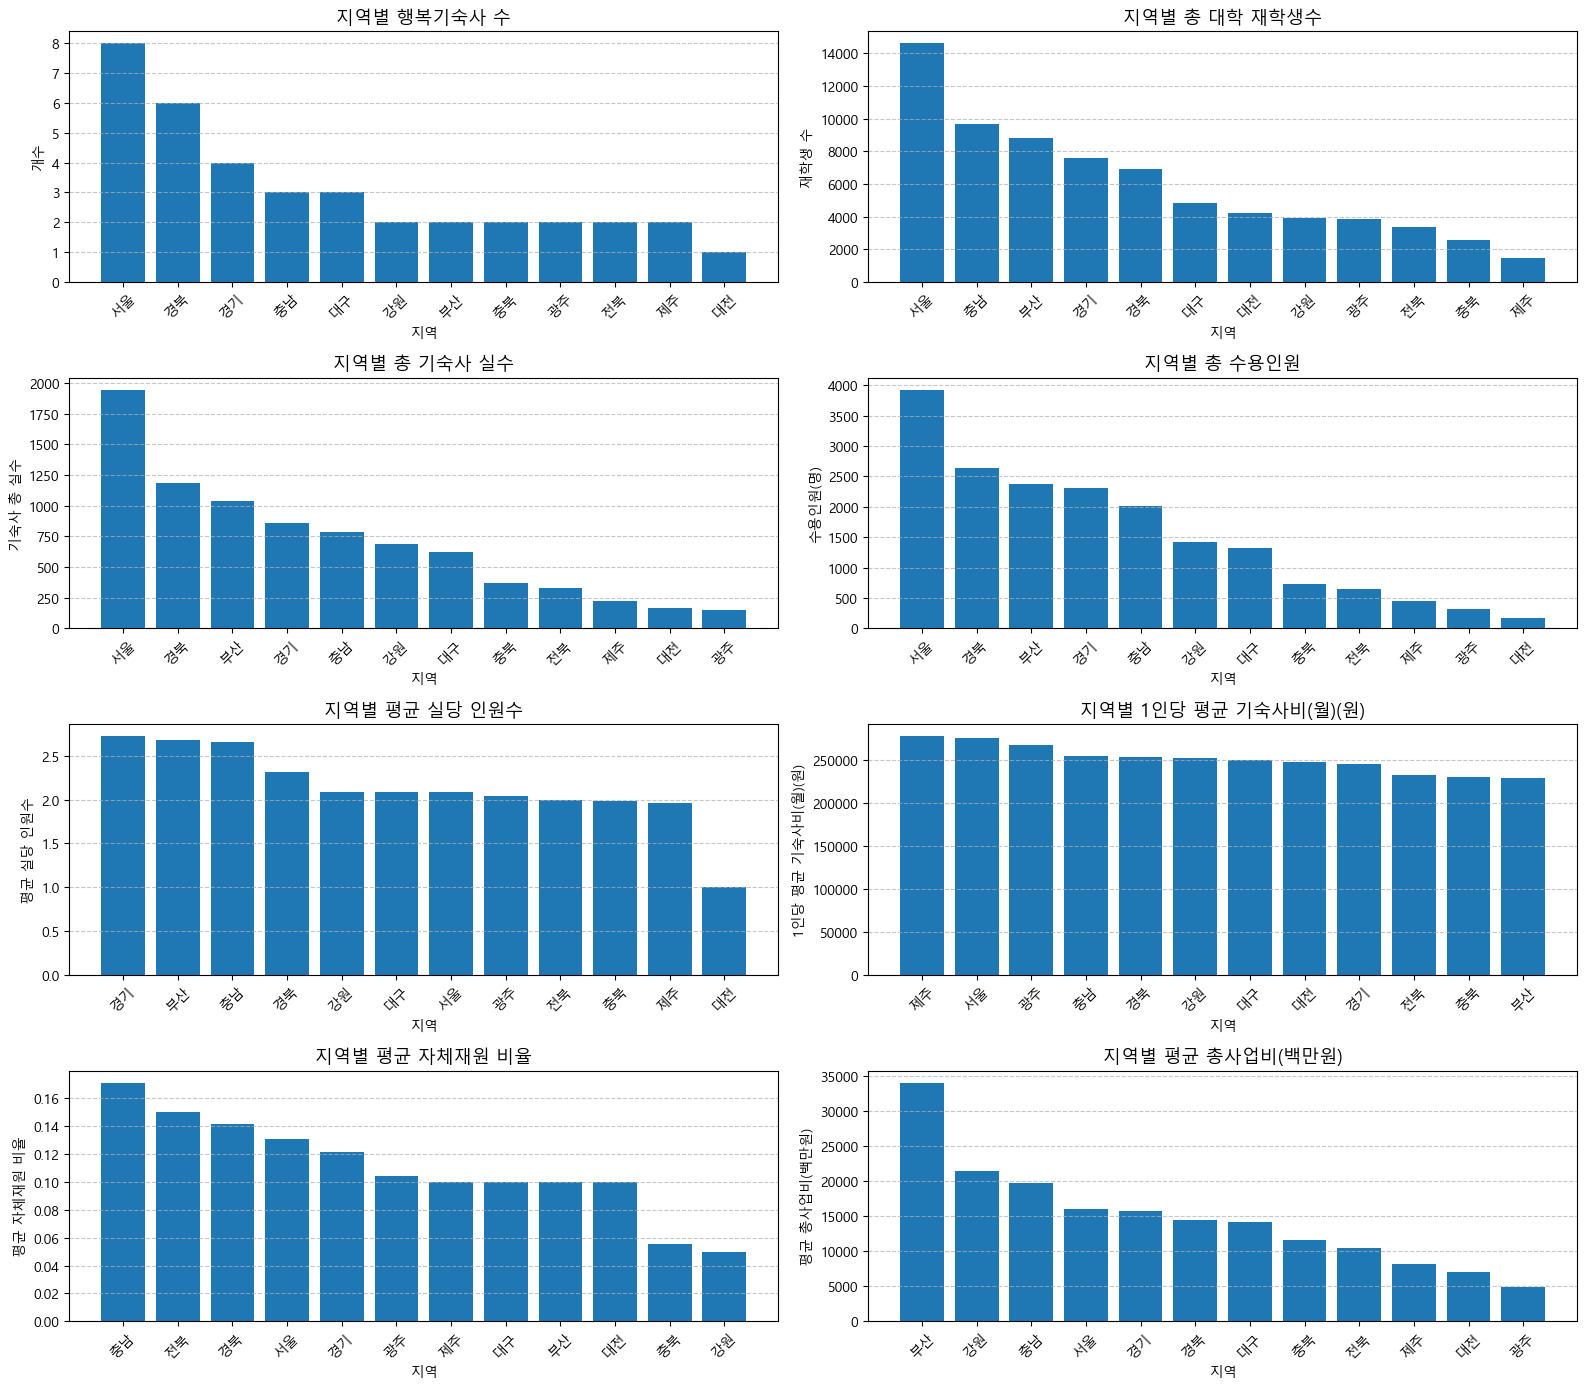

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()  # 1차원으로 변환 (반복문 쉽게)

# 그래프 데이터와 제목을 리스트로 묶기
graph_data = [
    (region_number, '지역별 행복기숙사 수', '개수'),
    (region_gross_people, '지역별 총 대학 재학생수', '재학생 수'),
    (region_room_num, '지역별 총 기숙사 실수', '기숙사 총 실수'),
    (region_capacity, '지역별 총 수용인원', '수용인원(명)'),
    (region_room_people, '지역별 평균 실당 인원수', '평균 실당 인원수'),
    (region_avg_per_cost, '지역별 1인당 평균 기숙사비(월)(원)', '1인당 평균 기숙사비(월)(원)'),
    (region_self_cost, '지역별 평균 자체재원 비율', '평균 자체재원 비율'),
    (region_avg_gross_funding, '지역별 평균 총사업비(백만원)', '평균 총사업비(백만원)')
]

# 반복문으로 subplot에 그래프 자동 배치
for ax, (data, title, ylabel) in zip(axes, graph_data):
    ax.bar(data.index, data.values)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('지역')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # 간격 자동 조정
plt.show()

## describe

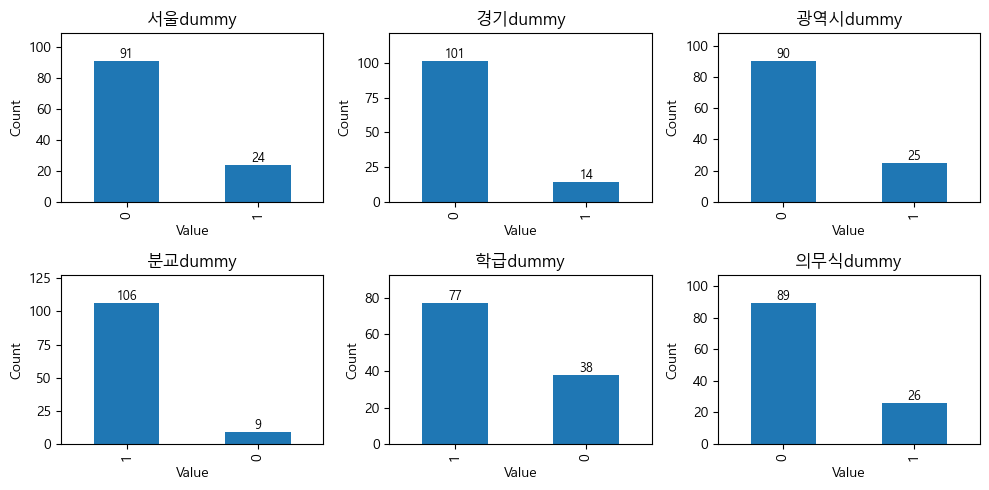

In [22]:
# 더비 변수 빈도 수
cols = ["서울dummy", "경기dummy", "광역시dummy", "분교dummy", "학급dummy", "의무식dummy"]
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 2x3 subplot

for ax, col in zip(axes.flatten(), cols):

    # 막대 그래프
    vc = df_merged[col].value_counts()
    vc.plot(kind='bar', ax=ax)

    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

    # 🔥 y축을 20% 더 크게 설정하여 숫자 안 잘리게
    max_val = vc.max()
    ax.set_ylim(0, max_val * 1.2)

    # 🔥 막대 위에 숫자 표시
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
# 더미 변수 목록
cols = ["서울dummy","경기dummy","광역시dummy","분교dummy","학급dummy","의무식dummy"]

# 빈도 수를 저장할 딕셔너리
freq_dict = {}

for col in cols:
    freq_dict[col] = df_merged[col].value_counts()

# 딕셔너리를 DataFrame으로 변환
freq_table = pd.DataFrame(freq_dict).fillna(0).astype(int)
print(freq_table)

   서울dummy  경기dummy  광역시dummy  분교dummy  학급dummy  의무식dummy
0       91      101        90        9       38        89
1       24       14        25      106       77        26


In [24]:
df_EDA4numberic.describe()

,재학생수,총 실수,운영된 기간,수용인원(명),연면적(미터제곱),재원(공자기금),재원(주택기금),재원(자체),자체재원 비율,실당 인원수,총기숙사비
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,1.150000e+02
mean,7610.791304,225.660870,5.426087,490.156522,10031.626087,4867.660870,8527.539130,1885.800000,0.121046,2.283902,1.220181e+08
std,6847.218589,155.808243,2.530727,315.010487,6417.999789,4177.069692,6001.950872,1564.215201,0.052324,0.742961,7.939673e+07
min,761.000000,41.000000,0.000000,74.000000,1697.000000,0.000000,1207.000000,0.000000,0.000000,0.805714,1.713000e+07
25%,3324.000000,136.000000,4.000000,298.000000,6319.000000,2351.000000,4360.000000,890.000000,0.100037,1.986667,6.847214e+07
50%,4945.000000,175.000000,6.000000,398.000000,8501.000000,3822.000000,6752.000000,1320.000000,0.100110,1.989817,1.024171e+08
75%,10685.000000,252.000000,7.000000,659.000000,13206.000000,6722.000000,10872.000000,2110.000000,0.123302,2.176004,1.586338e+08
max,29673.000000,814.000000,11.000000,1628.000000,30071.000000,18135.000000,27570.000000,6900.000000,0.300000,4.579710,3.994412e+08


## boxplot

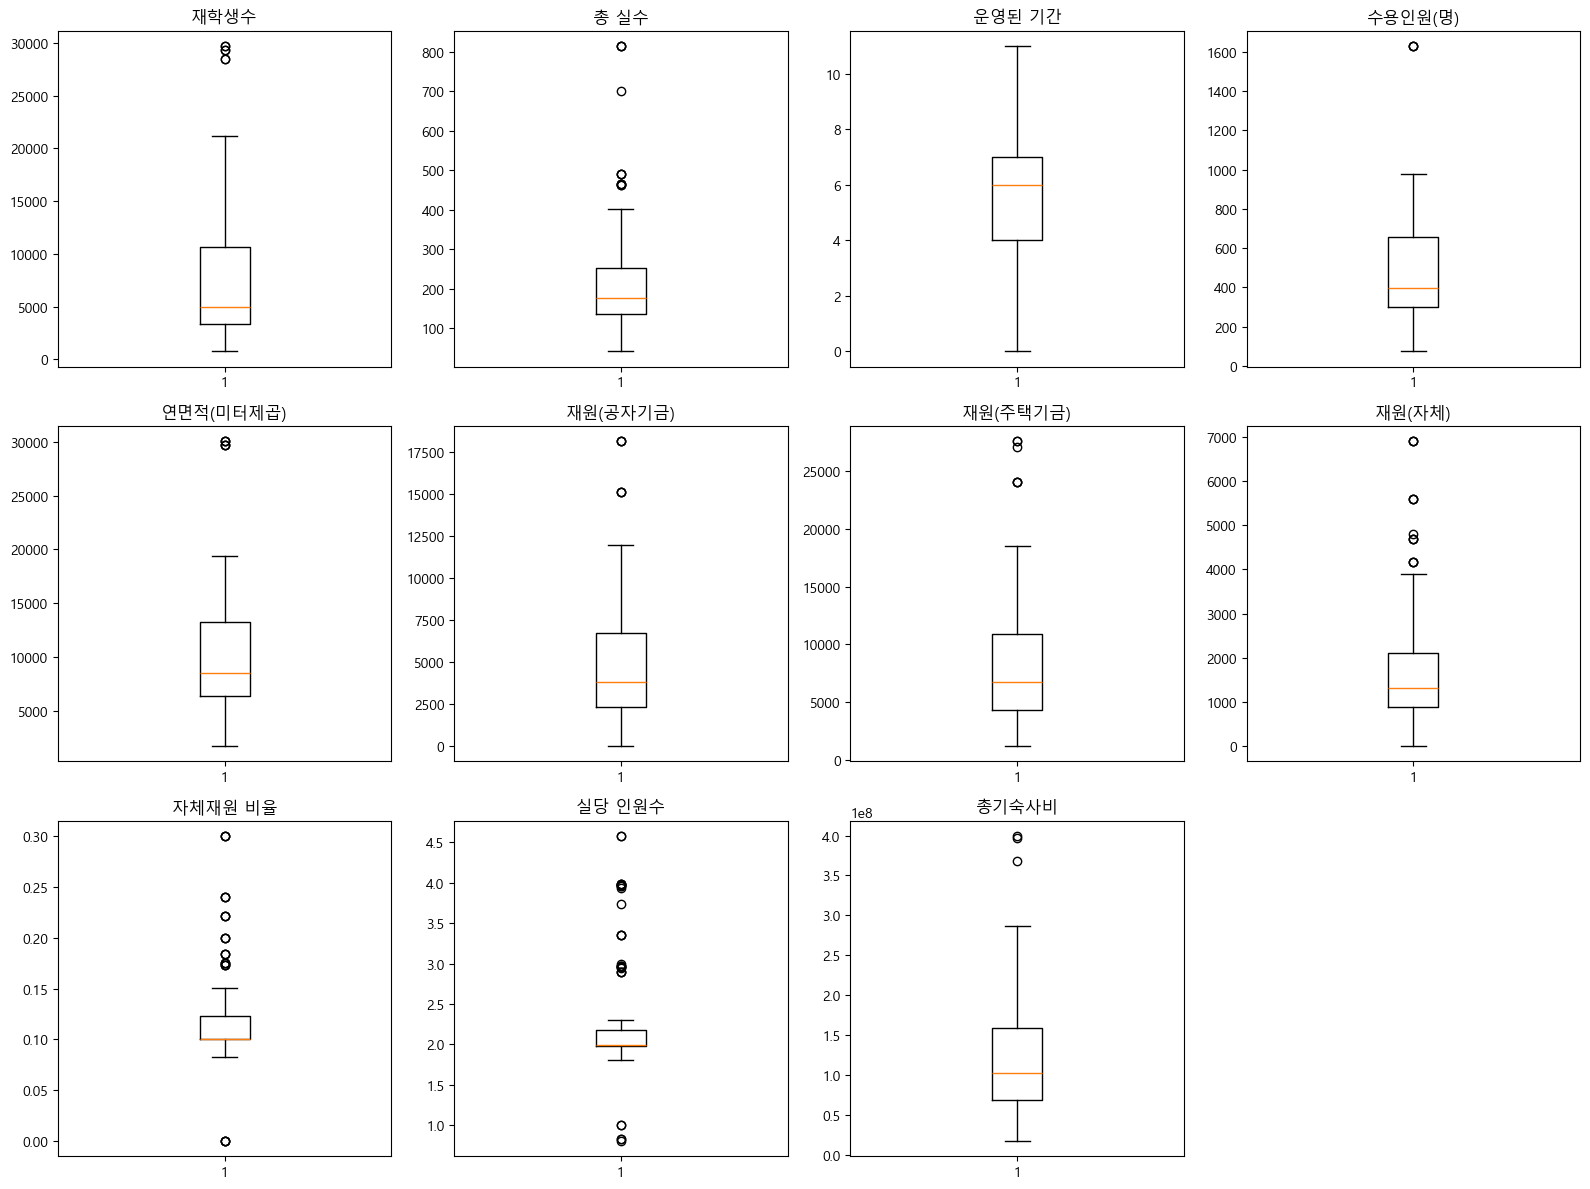

In [25]:

cols = df_EDA4numberic.columns
# subplot grid 계산 (예: 4행 4열 → 16칸)
import math
n = len(cols)
cols_per_row = 4
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, rows*4))

for ax, col in zip(axes.flatten(), cols):
    ax.boxplot(df_EDA4numberic[col])
    ax.set_title(col)

# 빈 subplot 제거
for ax in axes.flatten()[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 산점도

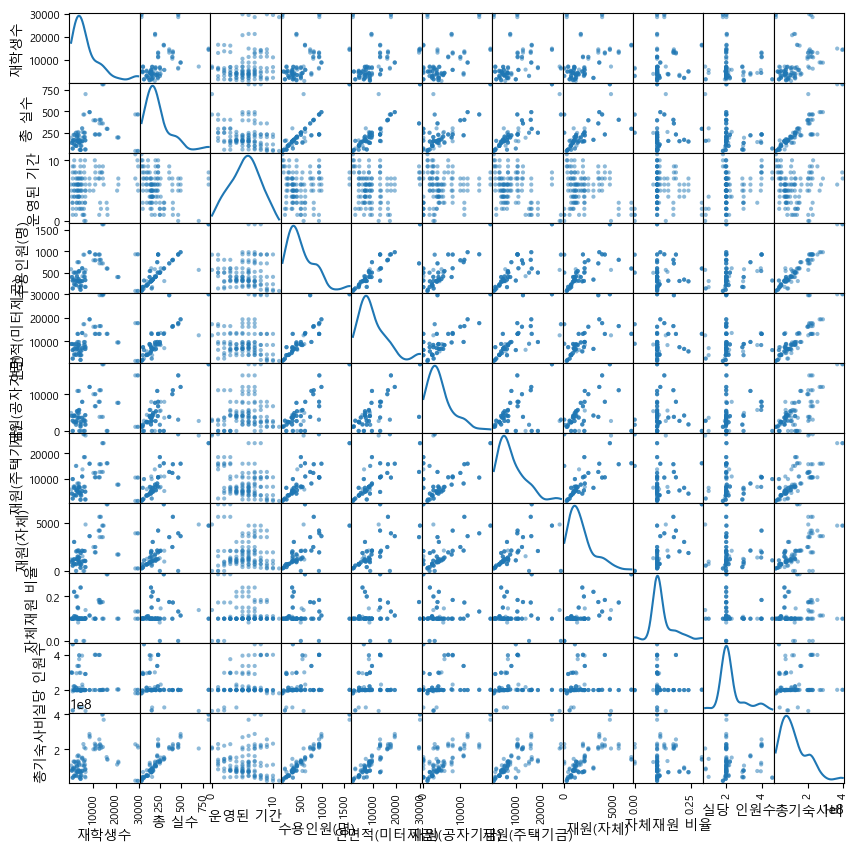

In [26]:
from pandas.plotting import scatter_matrix

cols = df_EDA4numberic.columns  # 보고 싶은 변수 선택
scatter_matrix(df_EDA4numberic[cols], figsize=(10,10), diagonal='kde')  # diagonal='kde' -> 히스토그램 대신 커널 밀도
plt.show()

## 상관계수 행렬 그래프

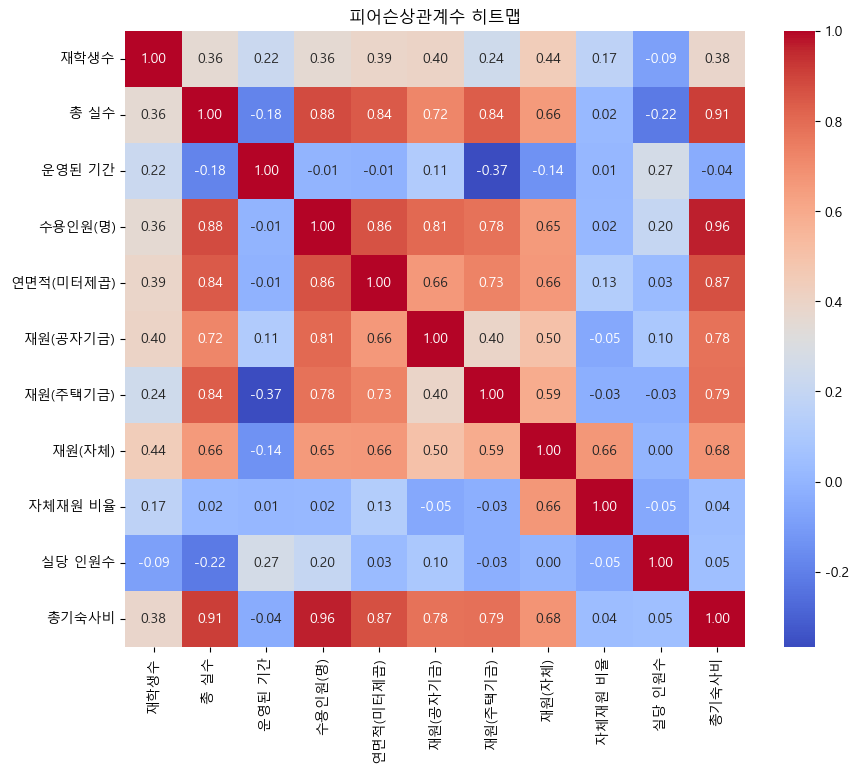

In [27]:

# 상관계수 계산
corr = df_EDA4numberic.corr()

# 히트맵 그리기
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('피어슨상관계수 히트맵')
plt.show()

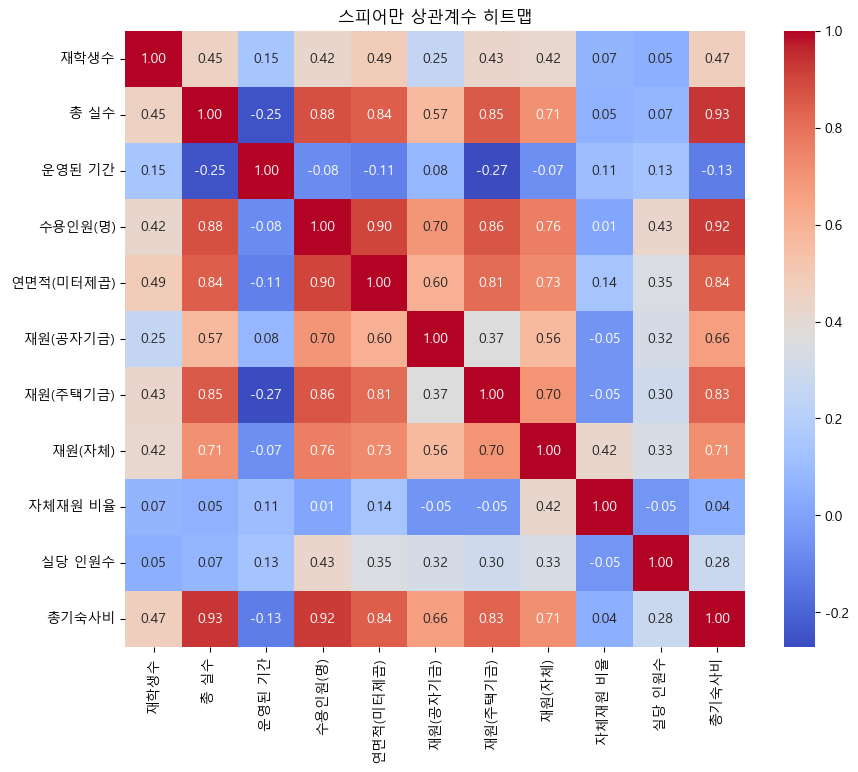

In [28]:
# 상관계수 계산
corr2 = df_EDA4numberic.corr(method='spearman')

# 히트맵 그리기
plt.figure(figsize=(10,8))
sns.heatmap(corr2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('스피어만 상관계수 히트맵')
plt.show()

## QQ plot

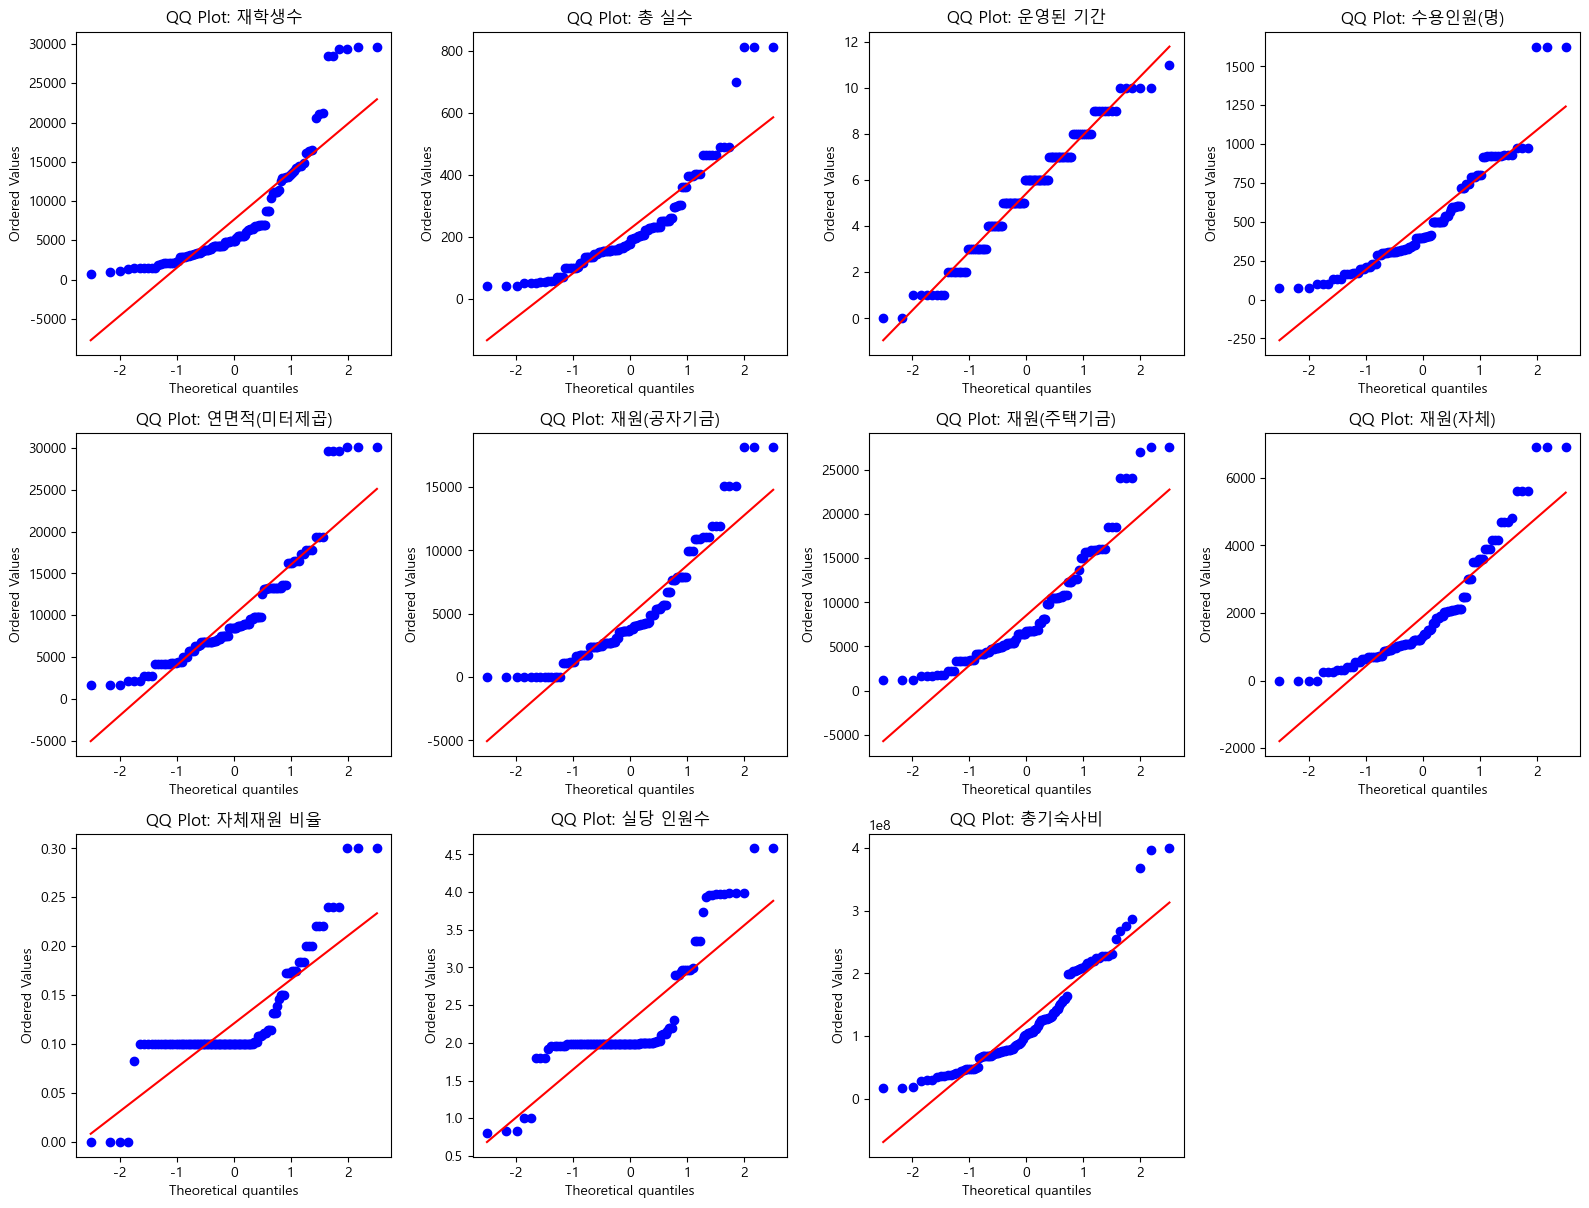

In [29]:
numeric_cols = df_EDA4numberic.columns

# subplot 행, 열 개수 자동 설정
n = len(df_EDA4numberic)
cols = 4
rows = (n + cols - 1) // cols  # 올림 나눗셈

plt.figure(figsize=(cols*4, rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    stats.probplot(df_EDA4numberic[col], dist="norm", plot=plt)
    plt.title(f'QQ Plot: {col}')

plt.tight_layout()
plt.show()

## 히스토그램

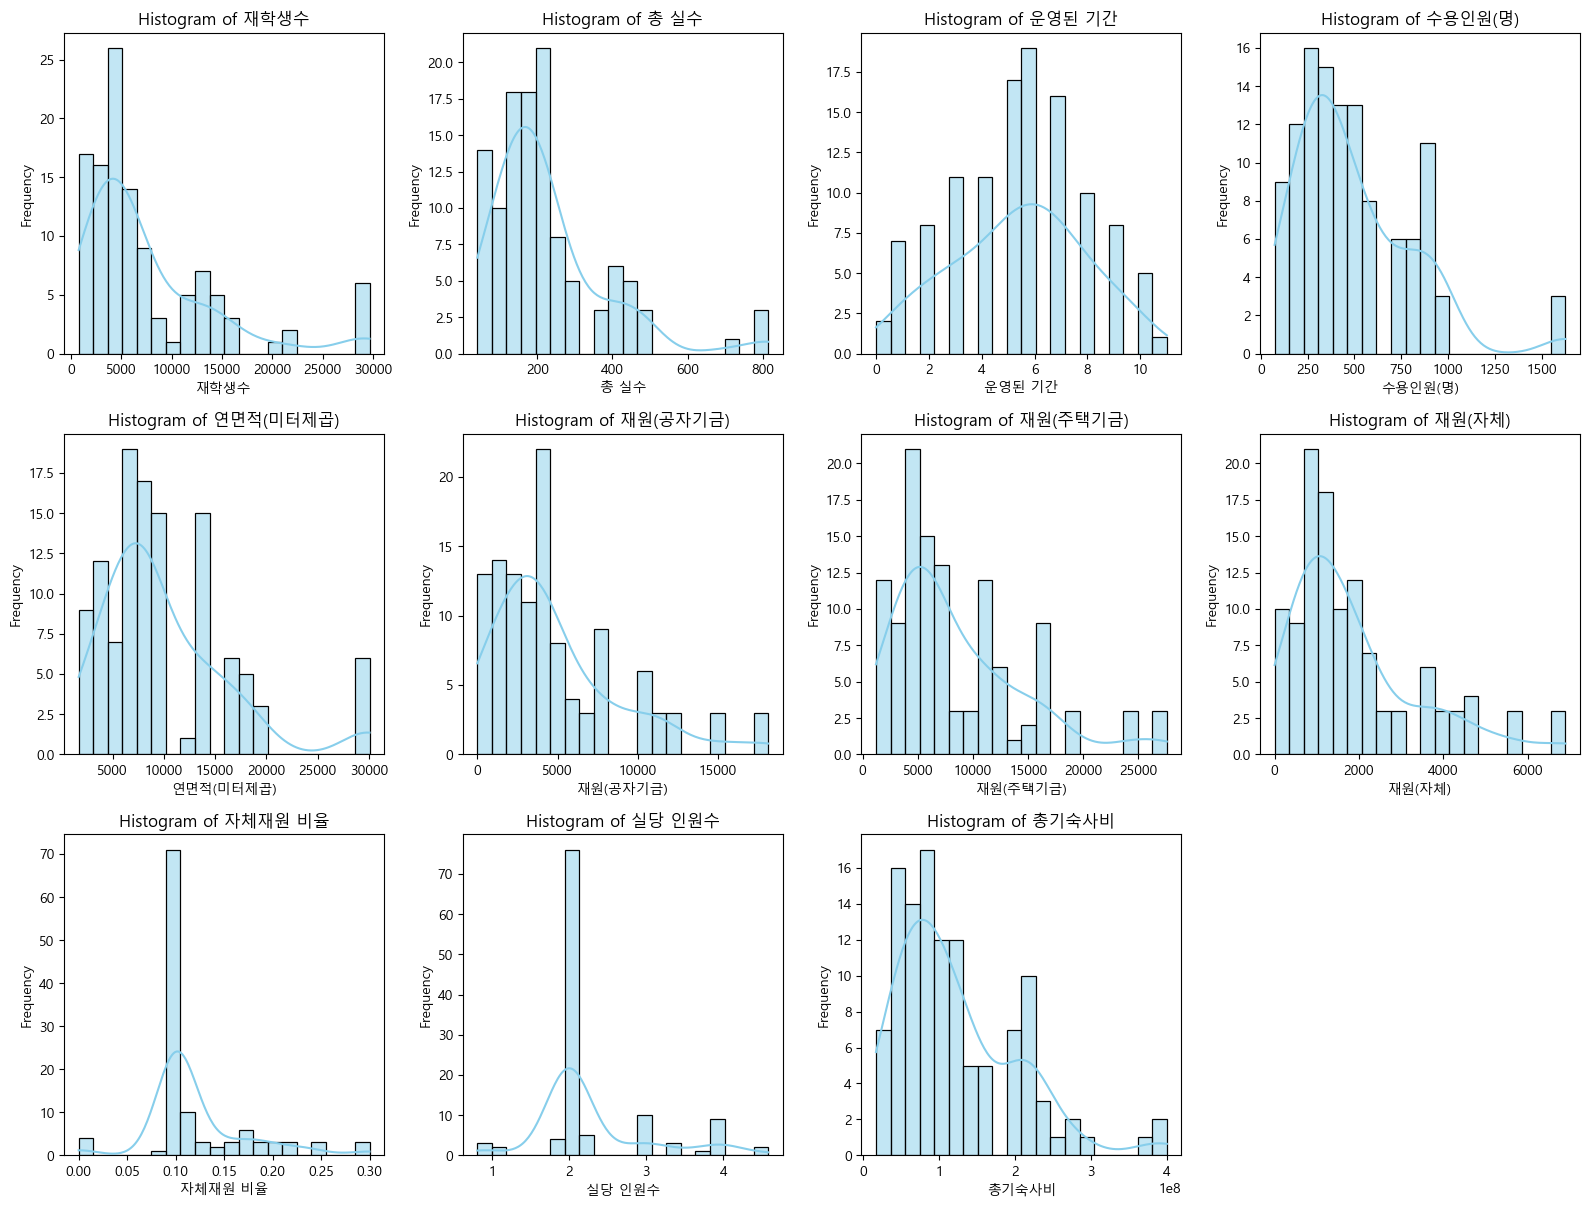

In [30]:
# subplot 행, 열 개수 자동 설정
n = len(df_EDA4numberic)
cols = 4
rows = (n + cols - 1) // cols  # 올림 나눗셈

numeric_cols = df_EDA4numberic.columns

plt.figure(figsize=(cols*4, rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_EDA4numberic[col], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 전처리

In [31]:
df_preprocessed = df_cleaned.copy()

## 데이터 통일 및 데이터 셋 분할
총 기숙사비를 기준으롤 4분위별로 균등하게 train set과 test set을 나누었다.

In [32]:
train_row = [89,14,104,57,60,23,92,46,21,55,16,49,68,62,69,53,79,82,103,10,85,61,33,66,29,93,27,63,22,31,65,7,99,72,37,26,115,76,96,100,24,58,108,25,87,13,114,50,6,45,32,98,1,70,12,40,34,11,52,80,51,64,38,39,83,78,2,43,9,48,74,5,36,56,15,110,75,47,90,44,81,109,20,41]
train_row = [ i-1 for i in train_row ]
test_row = [i for i in range(115) if i not in train_row]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

X = df_preprocessed.drop(columns=['총기숙사비'])
y = df_preprocessed['총기숙사비']

In [34]:
X_train  = X.iloc[train_row]
X_test = X.iloc[test_row]
y_train = y.iloc[train_row]
y_test = y.iloc[test_row]

In [35]:
kf= KFold(n_splits=5, shuffle=True, random_state=42)

# 인덱스 저장
fold_indices = list(kf.split(X_train))

In [36]:
fold_indices

[(array([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19, 20, 21,
         23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42,
         43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 56, 57, 59, 60, 61, 62, 63,
         64, 66, 67, 68, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83]),
  array([ 0,  4, 10, 12, 18, 22, 33, 35, 40, 47, 54, 55, 58, 65, 70, 73, 81])),
 (array([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 12, 13, 14, 15, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 35, 36, 37, 38, 40, 41, 43,
         46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
         65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82]),
  array([ 5,  9, 11, 16, 28, 30, 31, 34, 39, 42, 44, 45, 49, 64, 68, 76, 83])),
 (array([ 0,  1,  2,  4,  5,  9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23,
         24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43,
         44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 6

# 다중 회귀 분석

## 변수 선택법

In [37]:
def stepwise_selection(
    X, y,
    method='both',        # 'forward', 'backward', 'both'
    criterion='AIC',      # 'AIC', 'BIC', 'pvalue', 'R2', 'Cp'
    significance_level_in=0.05,
    significance_level_out=0.05,
    max_iter=100
):
    included = []
    
    # Backward 방법일 경우 모든 변수로 시작
    if method == 'backward':
        included = list(X.columns)
    
    best_score = np.inf if criterion in ['AIC', 'BIC', 'Cp'] else -np.inf
    
    def compute_score(model):
        if criterion == 'AIC':
            return model.aic
        elif criterion == 'BIC':
            return model.bic
        elif criterion == 'R2':
            return model.rsquared
        elif criterion == 'Cp':
            sse = np.sum(model.resid ** 2)
            n = len(y)
            p = model.df_model + 1
            # Full model의 MSE 계산
            full_model = sm.OLS(y, sm.add_constant(X)).fit()
            mse_full = np.sum(full_model.resid ** 2) / (n - X.shape[1] - 1)
            return sse / mse_full - (n - 2 * p)
    
    iteration = 0
    while iteration < max_iter:
        changed = False
        excluded = list(set(X.columns) - set(included))
        
        # Forward step
        if method in ['forward', 'both'] and len(excluded) > 0:
            scores_with_candidates = {}
            
            for feature in excluded:
                candidate_features = included + [feature]
                model = sm.OLS(y, sm.add_constant(X[candidate_features])).fit()
                
                if criterion == 'pvalue':
                    # 새로 추가된 변수의 p-value 확인
                    scores_with_candidates[feature] = model.pvalues[feature]
                else:
                    score = compute_score(model)
                    scores_with_candidates[feature] = score
            
            if len(scores_with_candidates) > 0:
                if criterion == 'pvalue':
                    best_feature = min(scores_with_candidates, key=scores_with_candidates.get)
                    if scores_with_candidates[best_feature] < significance_level_in:
                        included.append(best_feature)
                        changed = True
                else:
                    if criterion in ['AIC', 'BIC', 'Cp']:
                        best_feature = min(scores_with_candidates, key=scores_with_candidates.get)
                        best_score_candidate = scores_with_candidates[best_feature]
                        # 점수가 개선되는 경우에만 추가
                        if best_score_candidate < best_score:
                            included.append(best_feature)
                            best_score = best_score_candidate
                            changed = True
                    else:  # R2
                        best_feature = max(scores_with_candidates, key=scores_with_candidates.get)
                        best_score_candidate = scores_with_candidates[best_feature]
                        if best_score_candidate > best_score:
                            included.append(best_feature)
                            best_score = best_score_candidate
                            changed = True
        
        # Backward step
        if method in ['backward', 'both'] and len(included) > 1:
            scores_with_candidates = {}
            
            for feature in included:
                reduced_features = [f for f in included if f != feature]
                model = sm.OLS(y, sm.add_constant(X[reduced_features])).fit()
                
                if criterion == 'pvalue':
                    # 현재 모델에서 가장 큰 p-value를 가진 변수 찾기
                    current_model = sm.OLS(y, sm.add_constant(X[included])).fit()
                    scores_with_candidates[feature] = current_model.pvalues[feature]
                else:
                    score = compute_score(model)
                    scores_with_candidates[feature] = score
            
            if len(scores_with_candidates) > 0:
                if criterion == 'pvalue':
                    # p-value가 가장 큰 변수 제거
                    worst_feature = max(scores_with_candidates, key=scores_with_candidates.get)
                    if scores_with_candidates[worst_feature] > significance_level_out:
                        included.remove(worst_feature)
                        changed = True
                else:
                    if criterion in ['AIC', 'BIC', 'Cp']:
                        # 제거했을 때 점수가 개선되는 변수 찾기
                        best_removal = min(scores_with_candidates, key=scores_with_candidates.get)
                        removal_score = scores_with_candidates[best_removal]
                        if removal_score < best_score:
                            included.remove(best_removal)
                            best_score = removal_score
                            changed = True
                    else:  # R2
                        # R2의 경우 변수를 제거하면 항상 감소하므로 조심스럽게 처리
                        worst_removal = min(scores_with_candidates, key=scores_with_candidates.get)
                        removal_score = scores_with_candidates[worst_removal]
                        # R2가 크게 감소하지 않으면 제거
                        current_model = sm.OLS(y, sm.add_constant(X[included])).fit()
                        if current_model.rsquared - removal_score < 0.01:  # 임계값 조정 가능
                            included.remove(worst_removal)
                            best_score = removal_score
                            changed = True
        
        if not changed:
            break
        
        iteration += 1
    
    return included

In [38]:
methods = ['forward', 'backward', 'both']
criteria = ['AIC', 'BIC', 'pvalue', 'R2', 'Cp']

# 결과를 저장할 딕셔너리
selected_vars_dict = {}

check_X_train = X_train


for method in methods:
    for criterion in criteria:
        key = f"{method}_{criterion}"
        selected_vars = stepwise_selection(check_X_train, y_train, method=method, criterion=criterion)
        selected_vars_dict[key] = selected_vars

In [39]:
for i, j in selected_vars_dict.items() :
    print(f"method :{i} \nvariables: {j} ")
    print()

method :forward_AIC 
variables: ['수용인원(명)', '총 실수', '서울dummy', '분교dummy', '실당 인원수', '재원(자체)', '자체재원 비율', '재원(공자기금)', '운영된 기간', '재학생수'] 

method :forward_BIC 
variables: ['수용인원(명)', '총 실수', '서울dummy'] 

method :forward_pvalue 
variables: ['수용인원(명)', '총 실수', '서울dummy'] 

method :forward_R2 
variables: ['수용인원(명)', '총 실수', '서울dummy', '분교dummy', '실당 인원수', '재원(자체)', '자체재원 비율', '재원(공자기금)', '운영된 기간', '재학생수', '연면적(미터제곱)', '학급dummy', '광역시dummy', '재원(주택기금)', '의무식dummy', '경기dummy'] 

method :forward_Cp 
variables: ['수용인원(명)', '총 실수', '서울dummy', '분교dummy', '실당 인원수', '재원(자체)', '자체재원 비율', '재원(공자기금)', '운영된 기간', '재학생수'] 

method :backward_AIC 
variables: ['재학생수', '운영된 기간', '수용인원(명)', '재원(공자기금)', '재원(자체)', '자체재원 비율', '실당 인원수', '서울dummy', '분교dummy'] 

method :backward_BIC 
variables: ['재학생수', '운영된 기간', '수용인원(명)', '재원(공자기금)', '재원(자체)', '자체재원 비율', '실당 인원수', '서울dummy', '분교dummy'] 

method :backward_pvalue 
variables: ['재학생수', '운영된 기간', '수용인원(명)', '재원(공자기금)', '재원(자체)', '자체재원 비율', '실당 인원수', '서울dummy', '분교dumm

In [40]:
# 최종 결정된 변수
selected_variable = selected_vars_dict["both_AIC"]

## 훈련데이터로 다중 회귀 분석 만들기

In [41]:
X_train_LR = X_train[selected_variable].copy()
y_train_LR = y_train.copy()

X_test_LR = X_test[selected_variable].copy()
y_test_LR = y_test.copy()

In [42]:
X_train_const = sm.add_constant(X_train_LR, has_constant='add')
X_test_const = sm.add_constant(X_test_LR, has_constant='add')

# 모델 학습 및 예측
best_linear_model = sm.OLS(y_train_LR, X_train_const).fit()
y_pred = best_linear_model.predict(X_test_const)


# 평가
mse = mean_squared_error(y_test_LR, y_pred)
r2 = r2_score(y_test_LR, y_pred)

# Adjusted R² 직접 계산
n = len(y_test_LR)                   # 샘플 수
p = X_train_const.shape[1] - 1     # 독립변수 수 (상수항 제외)
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"RMSE={np.sqrt(mse):.3f}, \nR2={r2:.3f}, \nAdj_R2={adj_r2:.3f}")


RMSE=17832649.657, 
R2=0.953, 
Adj_R2=0.934


In [43]:
print(best_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  총기숙사비   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     232.5
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           1.59e-50
Time:                        13:07:57   Log-Likelihood:                -1503.5
No. Observations:                  84   AIC:                             3027.
Df Residuals:                      74   BIC:                             3051.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.488e+07   1.12e+07      5.772      0.0

In [44]:
# 해석용
best_linear_model.params

const       6.488380e+07
수용인원(명)     2.273235e+05
서울dummy     1.928695e+07
분교dummy    -1.738743e+07
실당 인원수     -1.621129e+07
재원(자체)      1.378454e+04
자체재원 비율    -2.353974e+08
재원(공자기금)   -1.657030e+03
운영된 기간      2.007732e+06
재학생수       -8.207937e+02
dtype: float64

In [45]:
# test set으로 모델 성능 평가
X_test_const_best = sm.add_constant(X_test_LR)

# 예측
y_pred = best_linear_model.predict(X_test_const_best)

# 성능 평가
mse = mean_squared_error(y_test_LR, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_LR, y_pred)
r2 = r2_score(y_test_LR, y_pred)



# Adjusted R² 직접 계산
n = len(y_test_LR)                   # 샘플 수
p = X_test_const_best.shape[1] - 1     # 독립변수 수 (상수항 제외)
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("📊 모델 성능 평가 결과")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"r2 : {r2:.3f}")
print(f"MAE : {mae:.3f}")
print(f"Adjusted R2: {adj_r2 :.3f}")



📊 모델 성능 평가 결과
MSE  : 318003393778764.312
RMSE : 17832649.657
r2 : 0.953
MAE : 12308437.367
Adjusted R2: 0.934


In [46]:
# 새 데이터에서 예측값 + 예측구간
pred_obj = best_linear_model.get_prediction(X_test_const)
pred_summary = pred_obj.summary_frame(alpha=0.05)  # 95% prediction & mean ci
# columns: mean, mean_se, mean_ci_lower, mean_ci_upper, obs_ci_lower, obs_ci_upper
print(pred_summary.head())

            mean       mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
2   3.125743e+07  8.954532e+06   1.341514e+07   4.909973e+07 -4.049107e+06   
3   1.610377e+08  4.672760e+06   1.517270e+08   1.703484e+08  1.291803e+08   
7   2.011303e+08  5.761421e+06   1.896504e+08   2.126102e+08  1.685728e+08   
16  2.161800e+08  8.998468e+06   1.982502e+08   2.341099e+08  1.808292e+08   
17  3.385834e+07  5.283961e+06   2.332982e+07   4.438687e+07  1.623980e+06   

    obs_ci_upper  
2   6.656398e+07  
3   1.928951e+08  
7   2.336878e+08  
16  2.515309e+08  
17  6.609271e+07  


## 회귀분석 가정들
 선형성 (Linearity)
 
 독립성 (Independence)

 등분산성 (Homoscedasticity)
 
 정규성 (Normality)
 
 다중공선성 없음 (No multicollinearity)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, normal_ad, acorr_ljungbox, linear_rainbow
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy import stats


def regression_diagnostics(model, X, y):
    """
    선형회귀 진단 + 가정위반 자동 경고 + 해결방법 제시
    model : statsmodels OLS 결과
    X : 독립변수 (상수항 must 포함)
    y : 종속변수 (Series)
    """

    fitted = model.fittedvalues
    residuals = model.resid

    print("="*90)
    print(" 1) 선형성 (Linearity)")
    print("="*90)
    plt.figure(figsize=(6,4))
    sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color':'red'})
    plt.title("Residuals vs Fitted")
    plt.show()

    # Rainbow Test (선형성 검정)
    rainbow_stat, rainbow_p = linear_rainbow(model)
    print(f"Rainbow Test p-value = {rainbow_p:.4f}")
    if rainbow_p < 0.05:
        print("⚠️ 선형성 위반 가능성 ↑ (p < 0.05)")
        print(" → 함수형태 변경 권장 (ex. 로그변환, 제곱항, 상호작용, GAM 등)")
    print()


    print("="*90)
    print(" 2) 등분산성 (Homoscedasticity)")
    print("="*90)

    # Breusch–Pagan Test
    bp_test = het_breuschpagan(residuals, X)
    bp_p = bp_test[1]
    print(f"Breusch–Pagan p-value = {bp_p:.4f}")

    # White Test
    white_test = het_white(residuals, X)
    white_p = white_test[1]
    print(f"White Test p-value = {white_p:.4f}")

    if bp_p < 0.05 or white_p < 0.05:
        print("⚠️ 등분산성 위반 ↑")
        print(" → 해결방법: 로그변환, Box–Cox 변환, WLS(가중회귀), Robust SE 사용")
    print()

    # 시각화
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, np.sqrt(np.abs(residuals)), alpha=0.6)
    plt.title("Scale-Location Plot")
    plt.xlabel("Fitted")
    plt.ylabel("√|Residuals|")
    plt.show()


    print("="*90)
    print(" 3) 정규성 (Normality)")
    print("="*90)

    # QQ plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title("Q-Q Plot")
    plt.show()

    # Shapiro Test
    shapiro = stats.shapiro(residuals)
    print(f"Shapiro-Wilk p-value = {shapiro.pvalue:.4f}")

    # Jarque-Bera Test
    jb_stat, jb_p, _, _ = jarque_bera(residuals)
    print(f"Jarque–Bera p-value = {jb_p:.4f}")

    if shapiro.pvalue < 0.05 or jb_p < 0.05:
        print("⚠️ 잔차 정규성 위반 ↑")
        print(" → 해결방법: 로그변환, Box–Cox 변환, Robust Regression 권장")
    print()


    print("="*90)
    print(" 4) 독립성 (Independence)")
    print("="*90)

    dw = durbin_watson(residuals)
    print(f"Durbin–Watson = {dw:.3f}")

    # Ljung-Box (잔차 자기상관)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_p = lb_test['lb_pvalue'].iloc[0]
    print(f"Ljung–Box p-value = {lb_p:.4f}")

    if lb_p < 0.05:
        print("⚠️ 자기상관 존재 가능 ↑")
        print(" → 해결방법: ARIMA terms, GLS, Newey-West SE")
    print()


    print("="*90)
    print(" 5) 다중공선성 (Multicollinearity)")
    print("="*90)

    vif_df = pd.DataFrame()
    vif_df['Variable'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_df)

    if any(vif_df['VIF'] > 10):
        print("⚠️ 강한 다중공선성 ↑")
        print(" → 해결방법: 변수 제거, PCA, Ridge Regression")
    print()


    print("="*90)
    print(" 6) 이상치 & 영향점 (Outliers / Leverage / Cook's D)")
    print("="*90)

    influence = OLSInfluence(model)
    cooks_d = influence.cooks_distance[0]

    plt.figure(figsize=(6,4))
    plt.stem(cooks_d, markerfmt=",")
    plt.title("Cook’s Distance")
    plt.show()

    # 영향점 기준: 4/n 이상
    threshold = 4 / len(X)
    outliers = np.where(cooks_d > threshold)[0]
    
    print(f"Cook’s D threshold = {threshold:.4f}")
    if len(outliers) > 0:
        print(f"⚠️ 영향점 존재: {outliers}")
        print(" → 해결방법: 해당 관측치 검토, Robust regression, 제거 고려")
    else:
        print("영향점 없음")
    print()

    print("="*90)
    print("진단 완료")
    print("="*90)

 1) 선형성 (Linearity)


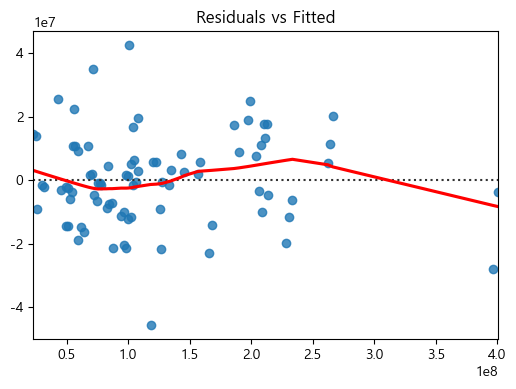

Rainbow Test p-value = 0.2193

 2) 등분산성 (Homoscedasticity)
Breusch–Pagan p-value = 0.2203
White Test p-value = 0.0379
⚠️ 등분산성 위반 ↑
 → 해결방법: 로그변환, Box–Cox 변환, WLS(가중회귀), Robust SE 사용



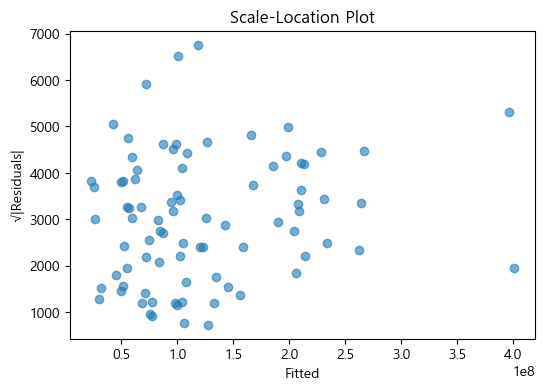

 3) 정규성 (Normality)


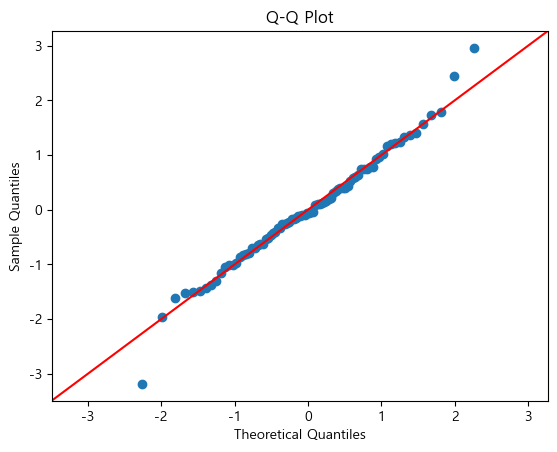

Shapiro-Wilk p-value = 0.7374
Jarque–Bera p-value = 0.3053

 4) 독립성 (Independence)
Durbin–Watson = 1.873
Ljung–Box p-value = 0.4873

 5) 다중공선성 (Multicollinearity)
   Variable        VIF
0     const  45.397882
1   수용인원(명)   6.532714
2   서울dummy   1.579352
3   분교dummy   1.097809
4    실당 인원수   1.246664
5    재원(자체)   9.404808
6   자체재원 비율   4.358179
7  재원(공자기금)   3.956673
8    운영된 기간   1.583894
9      재학생수   2.306691
⚠️ 강한 다중공선성 ↑
 → 해결방법: 변수 제거, PCA, Ridge Regression

 6) 이상치 & 영향점 (Outliers / Leverage / Cook's D)


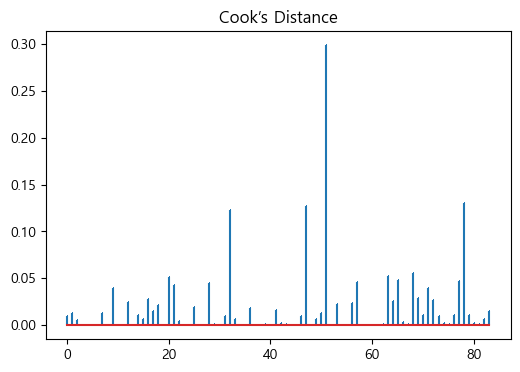

Cook’s D threshold = 0.0476
⚠️ 영향점 존재: [20 32 47 51 63 65 68 78]
 → 해결방법: 해당 관측치 검토, Robust regression, 제거 고려

진단 완료


In [48]:
regression_diagnostics(best_linear_model, X_train_const, y_train_LR)

## 아주대의 경우

In [49]:
selected_variable

['수용인원(명)',
 '서울dummy',
 '분교dummy',
 '실당 인원수',
 '재원(자체)',
 '자체재원 비율',
 '재원(공자기금)',
 '운영된 기간',
 '재학생수']

In [50]:
ajou_happy = np.insert(pd.read_csv("./아주대데이터.csv")[selected_variable].values, 0, 1) 

In [51]:
ajou_y_pred = best_linear_model.predict(ajou_happy)
print(ajou_y_pred)
print(ajou_y_pred / 990 )

[2.77693483e+08]
[280498.46811857]


# 결정 트리 

## 결정 트리 구하는 코드

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# GridSearchCV 파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10, 20, 50, 100, None],
    'ccp_alpha': [0.0,  0.005, 0.05],
    'max_features': ['sqrt', 'log2', 0.8]
}

#  Decision Tree Regressor 초기화
dt_regressor = DecisionTreeRegressor(random_state=42)


# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',  # 또는 'r2', 'neg_mean_absolute_error'
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=2,  # 진행 상황 출력
    return_train_score=True
)

# GridSearchCV 실행
print("\nGridSearchCV 시작...")
grid_search.fit(X_train, y_train)

print("\n" + "="*70)
print("GridSearchCV 완료!")
print("="*70)


GridSearchCV 시작...
Fitting 5 folds for each of 810 candidates, totalling 4050 fits

GridSearchCV 완료!


In [53]:

# 최적 파라미터 출력
print("\n최적 파라미터:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n최적 모델의 CV 점수:")
print(f"  Best CV Score (MSE): {-grid_search.best_score_:,.0f}")
print(f"  Best CV RMSE: {np.sqrt(-grid_search.best_score_):,.0f}원")

# 최적 모델 추출
best_model_dt_regressor = grid_search.best_estimator_



최적 파라미터:
  ccp_alpha: 0.0
  max_depth: 4
  max_features: 0.8
  max_leaf_nodes: 10
  min_samples_leaf: 1
  min_samples_split: 2

최적 모델의 CV 점수:
  Best CV Score (MSE): 1,305,948,251,422,148
  Best CV RMSE: 36,137,906원


In [54]:
# 사용된 feature의 인덱스 (split에 실제로 쓰인 변수들만)
used_features = np.unique(best_model_dt_regressor.tree_.feature)
# -1은 '리프 노드'를 의미하므로 제거
used_features = used_features[used_features != -1]

# 해당 feature 이름 출력
selected_features = X_train.columns[used_features]

print("🌳 이 트리에서 실제로 사용된 변수들:")
for f in selected_features:
    print(f)

🌳 이 트리에서 실제로 사용된 변수들:
분교dummy
총 실수
운영된 기간
수용인원(명)
재원(주택기금)
실당 인원수


In [55]:
# mse rmse r2값 출력하기 

y_pred_dt = best_model_dt_regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("MAE:", mean_absolute_error(y_test, y_pred_dt))
print("R2:", r2_score(y_test, y_pred_dt))


MSE: 225751349698153.0
RMSE: 15025024.116391728
MAE: 11851398.503548387
R2: 0.9669810687982392


## 모델 저장하기

In [56]:
# 1. 모델 저장
with open("best_model_dt_regressor3.pkl", "wb") as f:
    pickle.dump(best_model_dt_regressor, f)

print("✅ 모델이 'best_model_dt_regressor3.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_dt_regressor3.pkl'로 저장되었습니다.


In [57]:
# 2. 모델 불러오기
with open("best_model_dt_regressor3.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

✅ 모델이 성공적으로 불러와졌습니다.


## 트리 구조 시각화

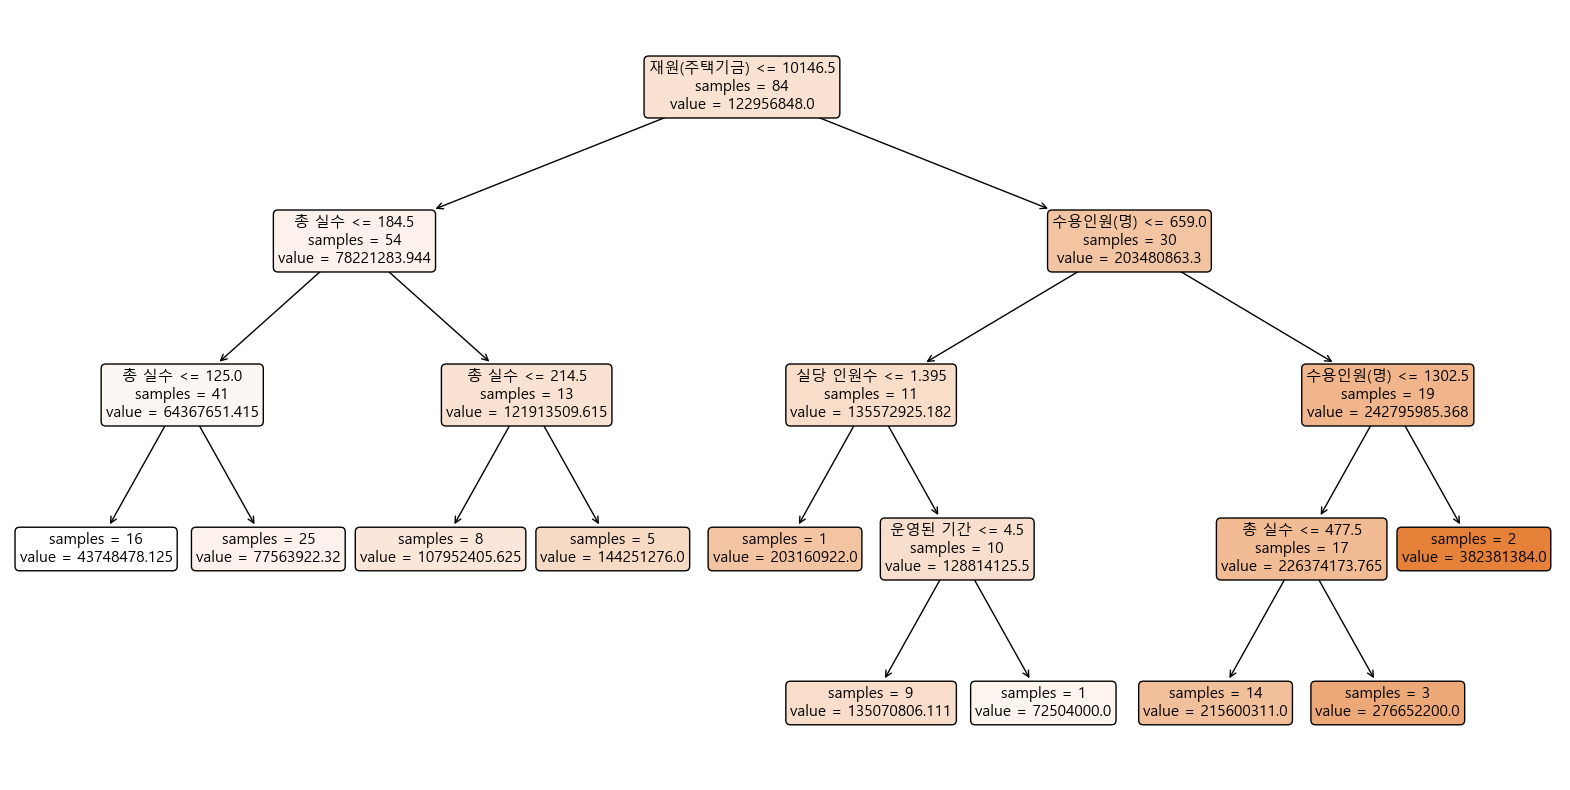

In [58]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_model_dt_regressor,
    feature_names=X_train.columns,
    filled=True,       # 노드 색상으로 값 강조
    rounded=True,      # 둥근 노드
    fontsize=11,
    impurity=False,    # squared error 제거
)
plt.show()

## 변수 중요도(Feature Importance) 시각화

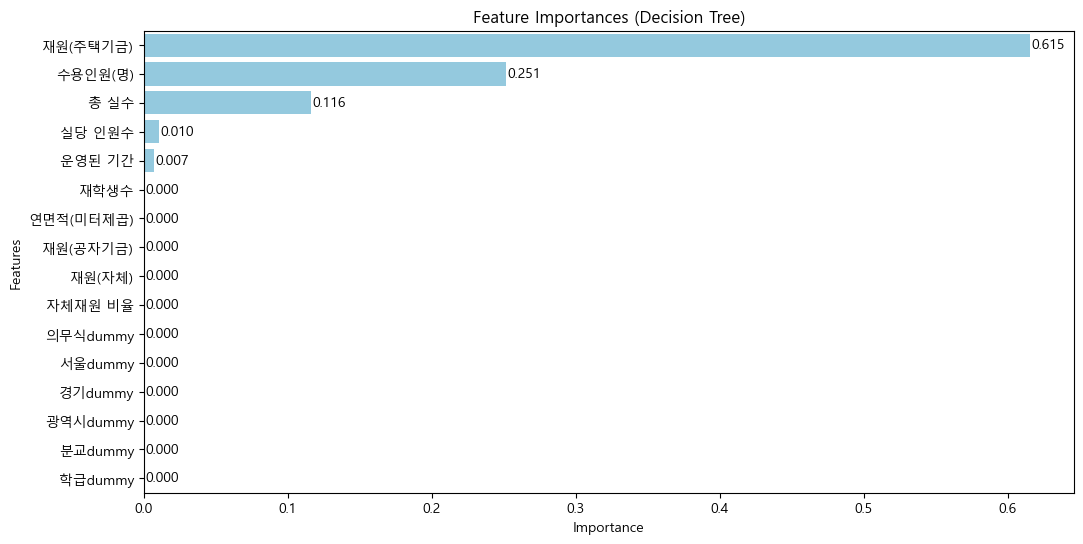

In [59]:
# 변수 중요도 추출
importances = best_model_dt_regressor.feature_importances_
features = X_train.columns

# DataFrame으로 정렬
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# 시각화

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color='skyblue')

# 각 막대 위에 수치 표시
for i, v in enumerate(feat_imp.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')
    
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## 실제 예측 vs 실제값 비교 (산점도)

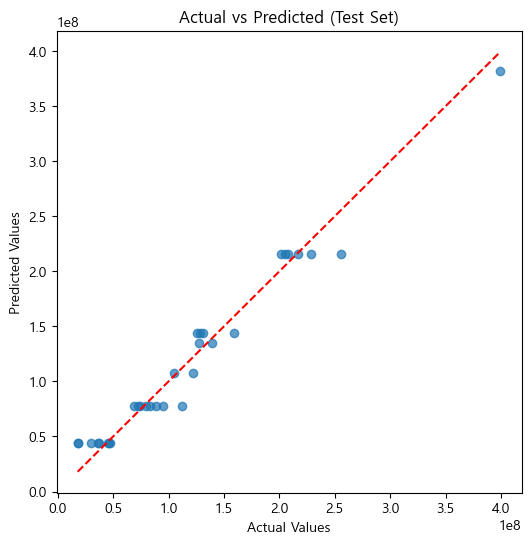

In [60]:
y_pred_test = best_model_dt_regressor.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

## 아주대의 경우

In [61]:
ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]

In [62]:
ajou_dt_pred = best_model_dt_regressor.predict(ajou_all_value)
print(ajou_dt_pred)
print(ajou_dt_pred / 990)

[2.766522e+08]
[279446.66666667]


# 랜덤 포레스트

## 랜덤 포레스트

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

#  모델 정의
rf = RandomForestRegressor(random_state=42)

#  하이퍼파라미터 후보 정의
param_grid = {
    'n_estimators': [300, 400, 500, 600],    # 트리 개수
    'max_depth': [5, 10, 15, 20, None],    # 트리 최대 깊이
    'max_features': ['sqrt', 'log2', 0.8],  # 사용 feature 비율
    'min_samples_split': [2, 5, 7, 10],    # 내부 노드를 나누기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]       # leaf 노드의 최소 샘플 수
}


#  GridSearchCV 설정 (MSE를 기준으로 함)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # MSE를 최소화
    cv=kf,
    n_jobs=-1,
    verbose=2
)


# GridSearchCV 실행
print("\nGridSearchCV 시작...")
grid_search_rf.fit(X_train, y_train)

print("\n" + "="*70)
print("GridSearchCV 완료!")
print("="*70)


GridSearchCV 시작...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

GridSearchCV 완료!


In [64]:

# 결과 출력
print("\n 최적 파라미터:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n 최적 모델의 CV 점수:")
print(f"  Best CV Score (MSE): {-grid_search_rf.best_score_:,.0f}")
print(f"  Best CV RMSE: {np.sqrt(-grid_search_rf.best_score_):,.0f}원")

#  최적 모델 추출
best_model_rf_regressor = grid_search_rf.best_estimator_


 최적 파라미터:
  max_depth: 5
  max_features: 0.8
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

 최적 모델의 CV 점수:
  Best CV Score (MSE): 791,792,039,745,452
  Best CV RMSE: 28,138,800원


In [65]:
# mse rmse r2값 출력하기 

y_pred_rf = best_model_rf_regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))

MSE: 204170630835508.03
RMSE: 14288828.882574948
MAE: 10242782.153883118
R2: 0.9701375162452334


## 랜덤 포레스트 변수 중요도(Feature Importance) 시각화

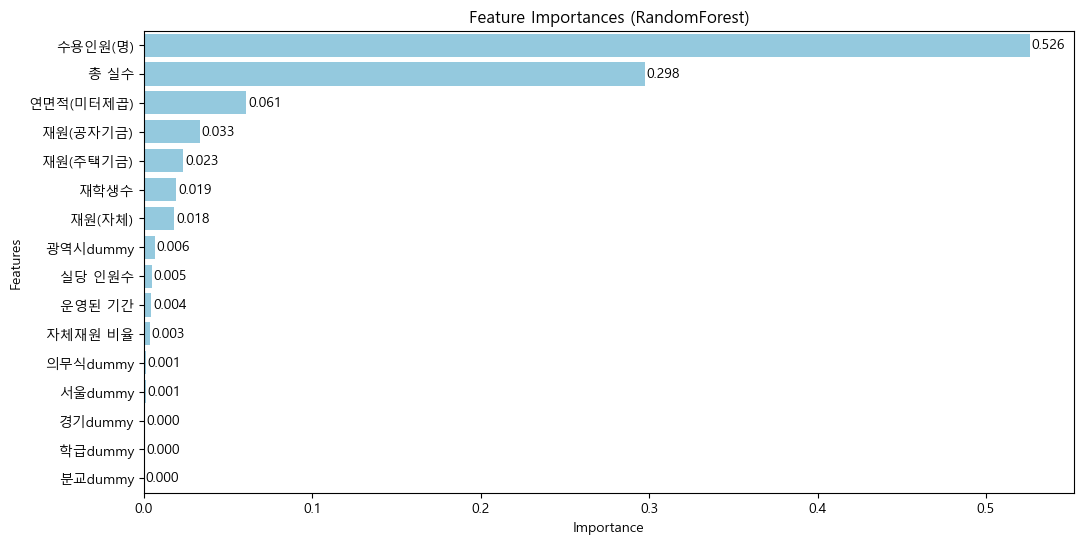

In [66]:
importances_rf = best_model_rf_regressor.feature_importances_
feat_imp = pd.Series(importances_rf, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color='skyblue')

# 각 막대 위에 수치 표시
for i, v in enumerate(feat_imp.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title("Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## 랜덤 포레스트 실제 예측 vs 실제값 비교 (산점도)

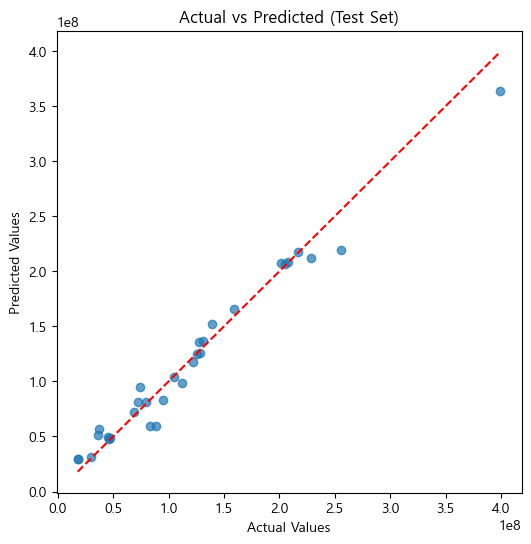

In [67]:
y_pred_test_m = best_model_rf_regressor.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_m, alpha=0.7)  # 실제값 vs 예측값
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # 이상적인 예측선 (y=x)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

## 랜덤 포레스트 아주대의 경우

In [68]:
ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]

In [69]:
ajou_rf_pred = best_model_rf_regressor.predict(ajou_all_value)
print(ajou_rf_pred)
print(ajou_rf_pred / 990)

[2.74386109e+08]
[277157.68589641]


## 랜덤 포레스트 모델 저장하기

In [70]:
# 1. 모델 저장
with open("best_model_rf_regressor.pkl", "wb") as f:
    pickle.dump(best_model_rf_regressor, f)

print("✅ 모델이 'best_model_rf_regressor.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_rf_regressor.pkl'로 저장되었습니다.


In [71]:
# 2. 모델 불러오기
with open("best_model_rf_regressor.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

✅ 모델이 성공적으로 불러와졌습니다.


# 그래디언트 부스팅

## 그래디언트 부스팅 코드 짜기

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

#  모델 초기화
gbr = GradientBoostingRegressor(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid_gbr = {
    'n_estimators': [300, 400, 500],        # 부스팅 단계 수
    'max_depth': [3, 5, 7, 9],                 # 각 트리 최대 깊이
    'min_samples_split': [2, 5, 7],        # 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],          # 리프 최소 샘플 수
    'max_features': [None, 'sqrt','log2', 0.8]     # 각 트리 학습용 feature 비율
}

# GridSearchCV 설정
grid_search_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_squared_error',  # 회귀: MSE 기준
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


# GridSearchCV 실행
print("\nGridSearchCV 시작...")
grid_search_gbr.fit(X_train, y_train)

print("\n" + "="*70)
print("GridSearchCV 완료!")
print("="*70)


GridSearchCV 시작...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

GridSearchCV 완료!


In [73]:
#  최적 파라미터 및 점수 확인
print("Best Parameters:", grid_search_gbr.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search_gbr.best_score_))

#  최적 모델
best_model_gb_regressor = grid_search_gbr.best_estimator_

Best Parameters: {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Best CV RMSE: 27270603.891176093


In [74]:
# mse rmse r2값 출력하기 
y_pred_gbr = best_model_gb_regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("R2:", r2_score(y_test, y_pred_gbr))

MSE: 191007636561866.97
RMSE: 13820551.239435675
MAE: 10122184.821802046
R2: 0.9720627672034742


## 그래디언트 부스팅 중요도(Feature Importance) 시각화

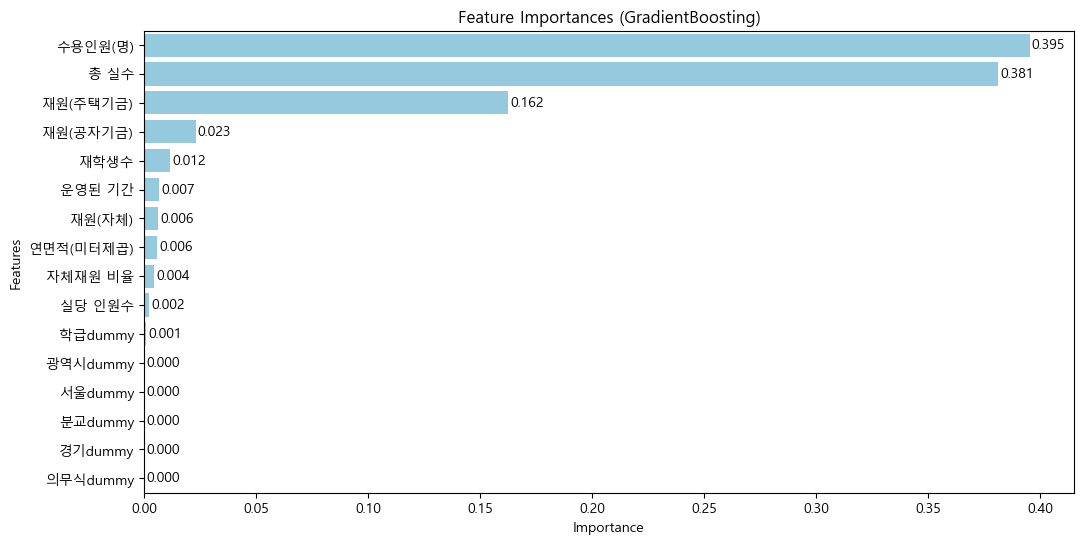

In [75]:
importances_gb = best_model_gb_regressor.feature_importances_
feat_imp = pd.Series(importances_gb, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color='skyblue')

# 각 막대 위에 수치 표시
for i, v in enumerate(feat_imp.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title("Feature Importances (GradientBoosting)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## 그래디언트 부스팅 실제 예측 vs 실제값 비교 (산점도)

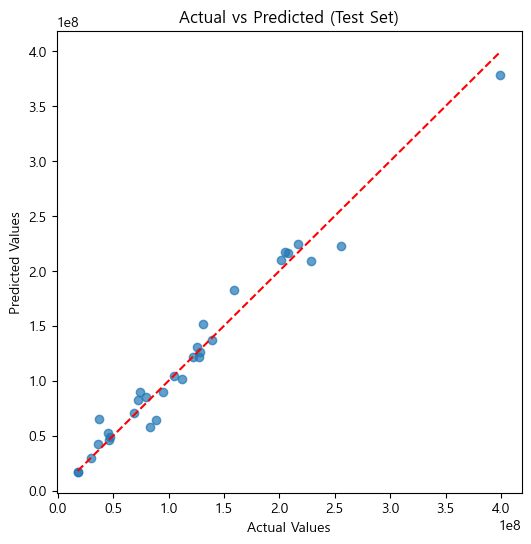

In [76]:
y_pred_test_m = best_model_gb_regressor.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_m, alpha=0.7)  # 실제값 vs 예측값
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # 이상적인 예측선 (y=x)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

## 그래디언트 부스팅 아주대의 경우

In [77]:
ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]

In [78]:
ajou_gb_pred = best_model_gb_regressor.predict(ajou_all_value)
print(ajou_gb_pred)
print(ajou_gb_pred / 990)

[3.16774947e+08]
[319974.69419741]


## 그래디언트 부스팅 모델 저장하기

In [79]:
# 1. 모델 저장
with open("best_model_gb_regressor.pkl", "wb") as f:
    pickle.dump(best_model_gb_regressor, f)

print("✅ 모델이 'best_model_gb_regressor.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_gb_regressor.pkl'로 저장되었습니다.


In [80]:
# 2. 모델 불러오기
with open("best_model_gb_regressor.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

✅ 모델이 성공적으로 불러와졌습니다.


# AdaBoosting

## AdaBoosting 코드 짜기

In [110]:
from sklearn.ensemble import AdaBoostRegressor
#  모델 초기화

base = DecisionTreeRegressor(max_depth=1)
ada = AdaBoostRegressor(estimator=base, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid_ada  = {
    'n_estimators': [300, 400, 500, 600, 700],
    'learning_rate': [0.01, 0.05],
    'loss': ['linear', 'square', 'exponential'],
    'estimator__max_depth': [3, 4, 5]
}

# GridSearchCV 설정
grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    scoring='neg_mean_squared_error',  # 회귀: MSE 기준
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


# GridSearchCV 실행
print("\nGridSearchCV 시작...")
grid_search_ada.fit(X_train, y_train)

print("\n" + "="*70)
print("GridSearchCV 완료!")
print("="*70)


GridSearchCV 시작...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

GridSearchCV 완료!


In [111]:
#  최적 파라미터 및 점수 확인
print("Best Parameters:", grid_search_ada.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search_ada.best_score_))

#  최적 모델
best_model_ada_regressor = grid_search_ada.best_estimator_

Best Parameters: {'estimator__max_depth': 4, 'learning_rate': 0.05, 'loss': 'square', 'n_estimators': 300}
Best CV RMSE: 27374848.703683626


In [112]:
# mse rmse r2값 출력하기 
y_pred_ada = best_model_ada_regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_ada))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ada)))
print("MAE:", mean_absolute_error(y_test, y_pred_ada))
print("R2:", r2_score(y_test, y_pred_ada))

MSE: 156477377258461.97
RMSE: 12509091.783917086
MAE: 9210398.498899302
R2: 0.9771132453416672


## AdaBoosting 중요도(Feature Importance) 시각화

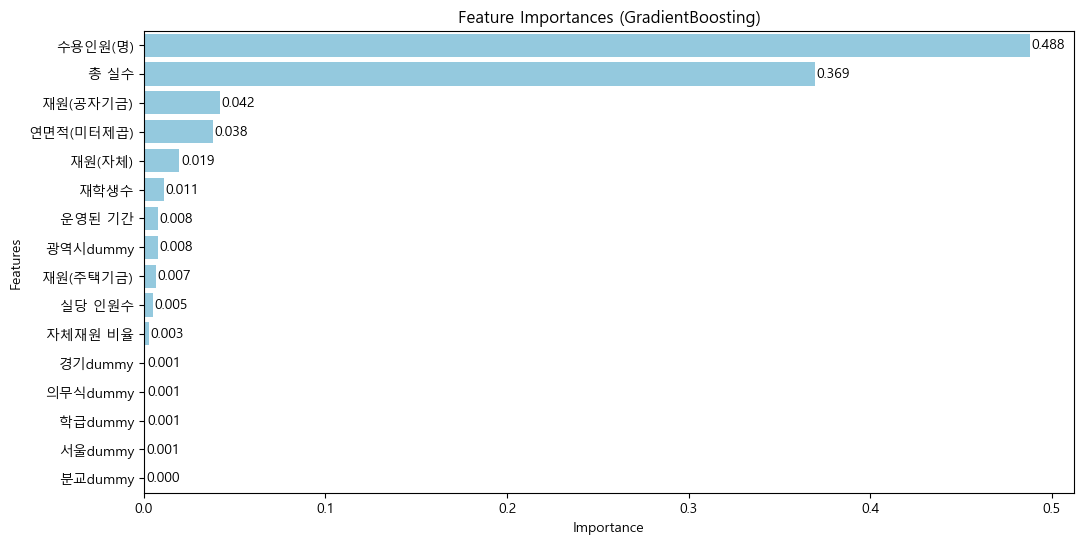

In [113]:
importances_ada = best_model_ada_regressor.feature_importances_
feat_imp = pd.Series(importances_ada, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color='skyblue')

# 각 막대 위에 수치 표시
for i, v in enumerate(feat_imp.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title("Feature Importances (GradientBoosting)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## AdaBoosting 실제 예측 vs 실제값 비교 (산점도)¶

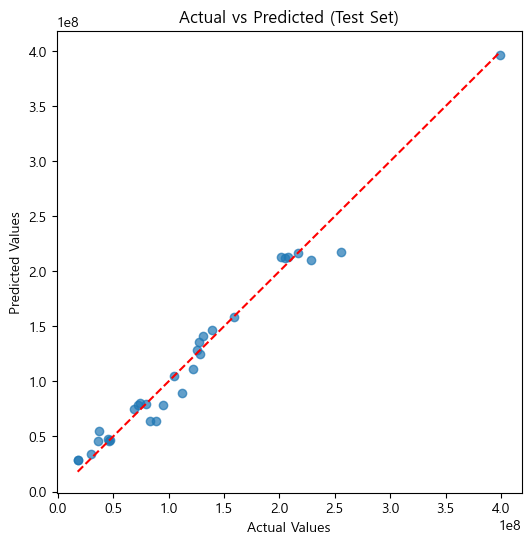

In [114]:
y_pred_test_m = best_model_ada_regressor.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_m, alpha=0.7)  # 실제값 vs 예측값
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # 이상적인 예측선 (y=x)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

## AdaBoosting 아주대의 경우

In [115]:
ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]

In [116]:
ajou_ada_pred = best_model_ada_regressor.predict(ajou_all_value)
print(ajou_ada_pred)
print(ajou_ada_pred / 990)

[2.730428e+08]
[275800.80808081]


## AdaBoosting 모델 저장하기

In [117]:
# 1. 모델 저장
with open("best_model_ada_regressor.pkl", "wb") as f:
    pickle.dump(best_model_ada_regressor, f)

print("✅ 모델이 'best_model_ada_regressor.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_ada_regressor.pkl'로 저장되었습니다.


In [118]:
# 2. 모델 불러오기
with open("best_model_ada_regressor.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

✅ 모델이 성공적으로 불러와졌습니다.


# XGBoost

## XGBoost 코드 짜기

In [90]:
from xgboost import XGBRegressor


xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',   # 빠르고 안정적
)

param_grid_xgb = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nXGBoost GridSearchCV 시작...")
grid_search_xgb.fit(X_train, y_train)
print("XGBoost 완료!")



XGBoost GridSearchCV 시작...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
XGBoost 완료!


In [91]:
print("Best Params:", grid_search_xgb.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search_xgb.best_score_))

best_model_xgb_regressor = grid_search_xgb.best_estimator_

# ----------------- 성능 ----------------- #
y_pred_test = best_model_xgb_regressor.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R2:", r2_score(y_test, y_pred_test))

Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700, 'subsample': 0.9}
Best CV RMSE: 26820107.61439362
MSE: 158015510352051.22
RMSE: 12570422.043513544
MAE: 8709201.741935484
R2: 0.9768882743243763


In [92]:
best_model_xgb_regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## XGBoost 중요도(Feature Importance) 시각화

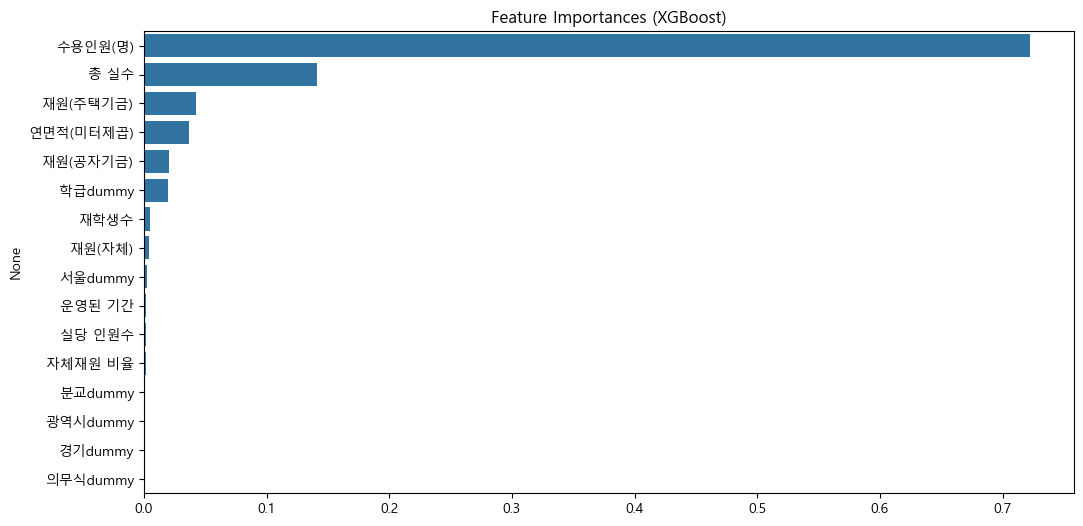

In [93]:
importances_xgb = pd.Series(best_model_xgb_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importances_xgb.values, y=importances_xgb.index)
plt.title("Feature Importances (XGBoost)")
plt.show()


## XGBoost 실제 예측 vs 실제값 비교 (산점도)

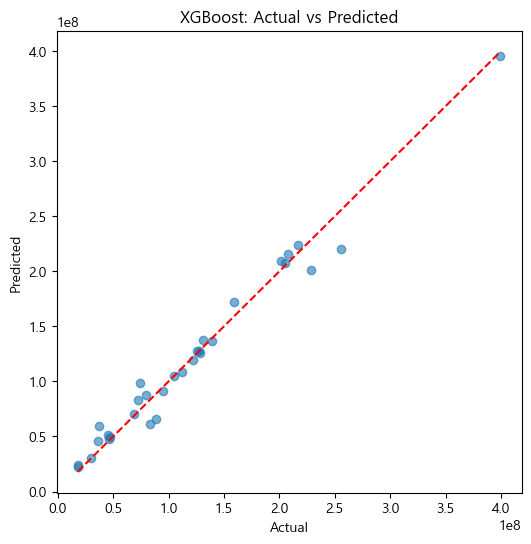

In [95]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")
plt.show()

## XGBoost 모델 저장하기

In [96]:
# 1. 모델 저장
with open("best_model_xgb_regressor.pkl", "wb") as f:
    pickle.dump(best_model_xgb_regressor, f)

print("✅ 모델이 'best_model_xgb_regressor.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_xgb_regressor.pkl'로 저장되었습니다.


In [97]:
# 2. 모델 불러오기
with open("best_model_xgb_regressor.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

✅ 모델이 성공적으로 불러와졌습니다.


## XGBoost 아주대의 경우

In [98]:
ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]

In [99]:
ajou_xgb_pred = best_model_xgb_regressor.predict(ajou_all_value)
print(ajou_xgb_pred)
print(ajou_xgb_pred / 990)

[2.5792954e+08]
[260534.89]


## SHAP 그래프 

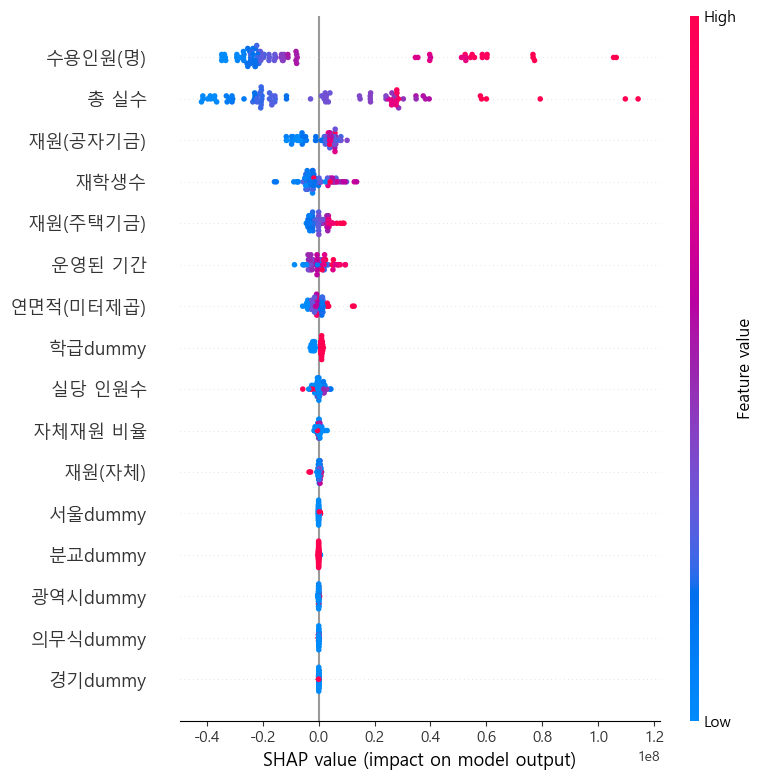

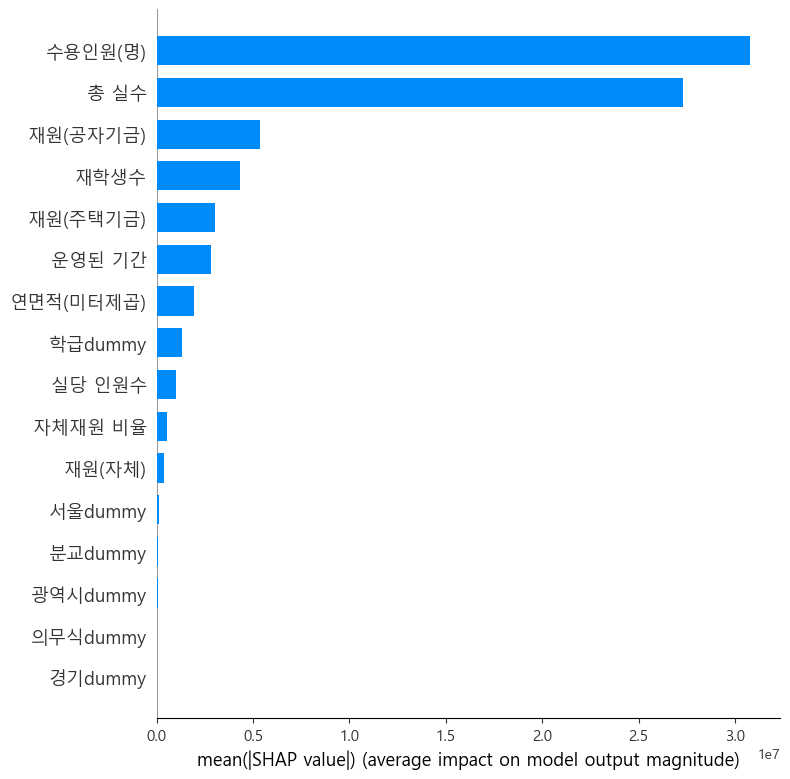

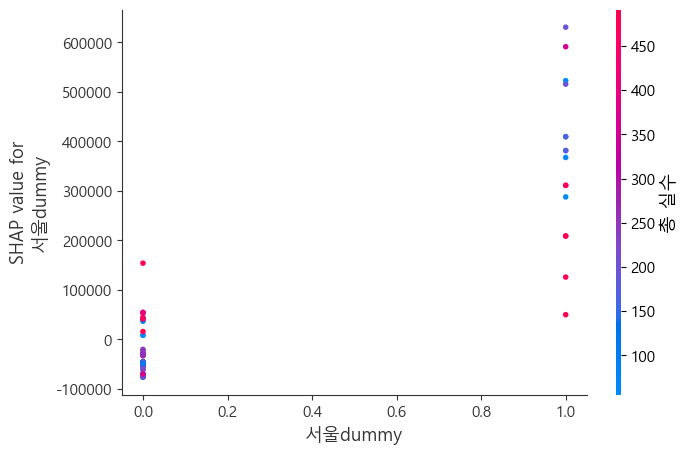

In [100]:
import shap
import xgboost as xgb

# 1) SHAP explainer 생성
explainer = shap.TreeExplainer(best_model_xgb_regressor)

# 2) SHAP 값 계산
shap_values = explainer.shap_values(X_train)

# 3) Summary plot
shap.summary_plot(shap_values, X_train)

# 4) Bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# 5) 한 개 데이터 포인트 설명
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# 6) 변수별 Dependence plot
shap.dependence_plot("서울dummy", shap_values, X_train)

# CatBoosting

## CatBoosting 코드 짜기

In [101]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    silent=True,  
    train_dir="C:/catboost_tmp"
)

param_grid_cat = {
    'iterations': [200, 300, 500],
    'depth': [3, 4, 5],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'l2_leaf_reg': [3, 5, 7, 9]
}

grid_search_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    scoring='neg_mean_squared_error',
    cv=kf, 
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nCatBoost GridSearchCV 시작...")
grid_search_cat.fit(X_train, y_train)
print("CatBoost 완료!")


CatBoost GridSearchCV 시작...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
CatBoost 완료!


In [102]:
print("Best Params:", grid_search_cat.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search_cat.best_score_))

best_model_cat = grid_search_cat.best_estimator_

Best Params: {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Best CV RMSE: 26892580.066702373


In [103]:
y_pred_test = best_model_cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R2:", r2_score(y_test, y_pred_test))


MSE: 177088760042216.03
RMSE: 13307470.084212702
MAE: 10217734.354515553
R2: 0.974098575303061


## CatBoosting 중요도(Feature Importance) 시각화

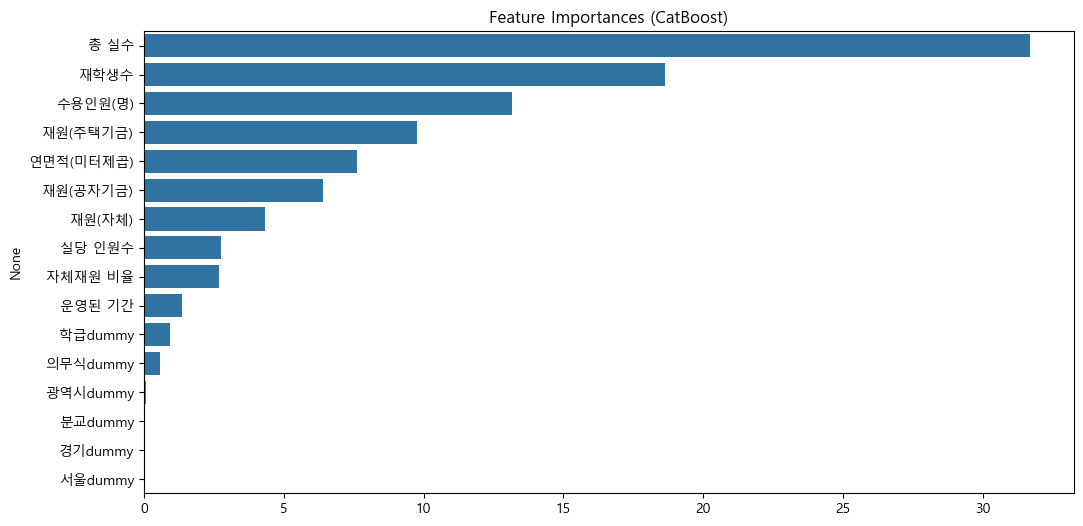

In [104]:
importances_cat = pd.Series(best_model_cat.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importances_cat.values, y=importances_cat.index)
plt.title("Feature Importances (CatBoost)")
plt.show()


## CatBoosting 실제 예측 vs 실제값 비교 (산점도)

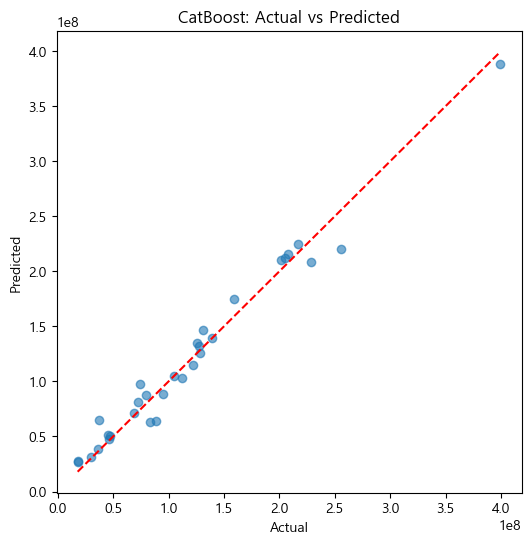

In [105]:
# 실제 vs 예측
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("CatBoost: Actual vs Predicted")
plt.show()

## CatBoosting 모델 저장하기

In [106]:
# ----------------- 모델 저장 ----------------- #
with open("best_model_catboost_regressor.pkl", "wb") as f:
    pickle.dump(best_model_cat, f)

print("✅ 모델이 'best_model_catboost_regressor.pkl'로 저장되었습니다.")


✅ 모델이 'best_model_catboost_regressor.pkl'로 저장되었습니다.


In [107]:
# ----------------- 모델 불러오기 ----------------- #
with open("best_model_catboost_regressor.pkl", "rb") as f:
    loaded_cat_model = pickle.load(f)

print("✅ 모델이 성공적으로 불러와졌습니다.")

best_model_cat = loaded_cat_model

✅ 모델이 성공적으로 불러와졌습니다.


## CatBoosting 아주대의 경우

In [108]:

ajou_all_value = pd.read_csv("./아주대데이터.csv")[X_train.columns]
ajou_cat_pred = best_model_cat.predict(ajou_all_value)

print(ajou_cat_pred)
print(ajou_cat_pred / 990)

[2.66216572e+08]
[268905.62828755]
